# Imports


In [1]:
import vip_hci

In [35]:
from vip_hci.fits import open_fits,write_fits
import numpy as np
from matplotlib import pyplot as plt
from hciplot import plot_frames
import pandas as pd
import seaborn as sns
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
import os


In [24]:
from CCFcore.PreProcess import SINFONI
from CCFcore.CrossCorr import CrossCorr
from CCFcore import removeTelluric
import multiprocessing
from contextlib import contextmanager
from CCFcore import removeTelluric,applyFilter,measureSpatialSpec
from vip_hci.preproc.cosmetics import frame_center,cube_crop_frames,frame_crop
from vip_hci.preproc.derotation import cube_derotate
from vip_hci.metrics.stim import stim_map
from vip_hci.metrics.snr_source import snrmap,snr
from vip_hci.var.shapes import mask_circle
from vip_hci.metrics.roc import compute_binary_map
from vip_hci.psfsub import median_sub

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from generateData import loadPatchData
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from sklearn.metrics import auc,roc_curve

In [5]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [6]:
plt.style.use('seaborn')

In [7]:
from hciplot import plot_frames
from vip_hci.fm.fakecomp import cube_inject_companions

# Data


# Methods 

## Fake companion insertion

In [31]:
 temp_path = "/mnt/disk12tb/Users/rakesh/SpatialDetection//Templates/BT-Settl_M-0.0a+0.0/"
    #fl_insert="lte1300-3.00-0.0a+0.0.BT-settl-giant-2013.cf250.tm1.0-0.0.R1-g12p0sc2.spid.fits"
fl_insert="lte013.0-3.0-0.0a+0.0.BT-Settl.spec.fits.gz"
datapath="/mnt/disk12tb/Users/rakesh/HD179218/"
cube = open_fits(datapath+"ASDI_cube.fits")
data_waves= open_fits(datapath+"lbda_vec")
fwhm = open_fits(datapath+"fwhm_vec.fits")
rot_angles = open_fits(datapath+"derot_angles.fits")
psf_template = open_fits(datapath+"PSF_template.fits")


Fits HDU-0 data successfully loaded. Data shape: (2005, 83, 61, 61)
Fits HDU-0 data successfully loaded. Data shape: (2005,)
Fits HDU-0 data successfully loaded. Data shape: (2005,)
Fits HDU-0 data successfully loaded. Data shape: (83,)
Fits HDU-0 data successfully loaded. Data shape: (2005, 13, 13)


In [20]:
rot_angles[-1]-rot_angles[0]

-46.18347

In [10]:
np.median(fwhm)

4.8527474

In [32]:
vels=np.linspace(-2000,2000,50)
CC=CrossCorr(vels)
temp_flux,temp_waves=CC.processTemplate(temp_path+fl_insert)

Now reading /mnt/disk12tb/Users/rakesh/SpatialDetection//Templates/BT-Settl_M-0.0a+0.0/lte013.0-3.0-0.0a+0.0.BT-Settl.spec.fits.gz


In [38]:
from astropy.io import fits
dat = fits.open(temp_path+fl_insert)

In [41]:
dat

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f04ec2cde90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f04ec2cd490>]

In [37]:
help(open_fits)

Help on function open_fits in module vip_hci.fits.fits:

open_fits(fitsfilename, n=0, header=False, ignore_missing_end=False, precision=<class 'numpy.float32'>, return_memmap=False, verbose=True, **kwargs)
    Load a fits file into a memory as numpy array.
    
    Parameters
    ----------
    fitsfilename : string or pathlib.Path
        Name of the fits file or ``pathlib.Path`` object
    n : int, optional
        It chooses which HDU to open. Default is the first one.
    header : bool, optional
        Whether to return the header along with the data or not.
    precision : numpy dtype, optional
        Float precision, by default np.float32 or single precision float.
    ignore_missing_end : bool optional
        Allows to open fits files with a header missing END card.
    return_memmap : bool, optional
        If True, the function returns the handle to the FITS file opened by
        mmap. With the hdulist, array data of each HDU to be accessed with mmap,
        rather than b

In [34]:
temp_orig_wav = fits(temp_path+fl_insert)

Fits HDU-0 data successfully loaded. Data shape: ()


In [36]:
os.path.isfile(temp_path+fl_insert)

True

In [12]:
contrast = 5e-04
rad_dist = 23.0
theta = 60.0
center = frame_center(cube[10,10,:,:])
stellar_spec=measureSpatialSpec(cube[:,10,:,:],center,fwhm)
st_spec_new=sum(stellar_spec[::])
temp_downsampled=np.interp(data_waves,temp_waves,temp_flux)
temp_new = temp_downsampled/sum(temp_downsampled)                                                                   
temp_insert=st_spec_new*contrast*temp_new
comp_spec_added=np.zeros_like(psf_template)
print("Insert a companion at a rad_dist {0:3.2f} pixels, theta {1:3.2f} and contrast of {2:1.0e}".format(rad_dist,theta,contrast))                                         

Insert a companion at a rad_dist 23.00 pixels, theta 60.00 and contrast of 5e-04


In [13]:
masked_psf = mask_circle(psf_template,radius=4,mode='out')
psf_cropped = cube_crop_frames(psf_template,size=11)

New shape: (2005, 11, 11)


In [ ]:
fake_comp_cube,pos = cube_inject_companions(cube,
                                psf_template = psf_cropped,
                                angle_list=rot_angles,
                                flevel=temp_insert,
                                rad_dists=rad_dist,
                                plsc=0.25,
                                theta = theta,
                                n_branches = 1,
                                full_output=True)

In [26]:
fake_comp_cube.shape

(2005, 83, 61, 61)

In [115]:
pos[0][1]

24.000000000000004

In [28]:
snr(np.mean(fake_comp_cube[:,:,:].mean(axis=1),axis=0),(pos[0][0],pos[0][1]),fwhm=4.8,verbose=True)

S/N for the given pixel = -2.253
Integrated flux in FWHM test aperture = 312.350
Mean of background apertures integrated fluxes = 360.667
Std-dev of background apertures integrated fluxes = 21.085


-2.253032704990337

In [20]:
insert_spec2 = measureSpatialSpec((fake_comp_cube[:,0,:,:]),[pos[0][1],pos[0][0]],fwhm)

In [22]:
CC.compareFluxes(data_waves,
                 insert_spec2,
        temp_waves,
        temp_flux,
        101,
        1,
        noise=0,
        wmin_wmax_tellurics=[1.81,1.93]
        )

[1.81, 1.93]
SNR is 5.10


/mnt/diskss/home/rnath/PhD/CCF_code/CCFcore/CrossCorr.py:167: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  noise_floor=np.sqrt(np.std(final[locs_noise_l])**2\
/mnt/diskss/home/rnath/PhD/CCF_code/CCFcore/CrossCorr.py:168: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  +np.std(final[locs_noise_h])**2)


(array([-24285922.70645167, -10368937.38045316,  -7956091.04928847,
         -6949789.52818378, -10781416.58566847,   2402940.40561534,
         -2259932.01599619,   8798192.91419891,   2178463.7431987 ,
        -17851432.36499998,  12932166.56746371,  17263189.4076033 ,
         -6691034.50241414,  -2155534.49937359,  19961711.21094451,
         28962559.87564254,   6755115.74732373,  -6567598.97446262,
        -27815767.01598982, -22563032.10965422,   2724311.13883885,
        -11318770.78101681,  -5791200.73220266,  37092089.62754695,
         77985643.84071733,  72771846.91322455,   6627508.85737901,
          4019141.23457006,   -481842.98451151, -15990468.6779745 ,
        -13703381.49505314, -17864443.55322268,  -9938439.19715372,
          5800863.30666387,  -7998015.5928076 ,   2605934.15486518,
         13061632.18694159,   9571557.18463075,  12071452.14405289,
         -6681836.01167897, -13656877.4313073 , -20528883.01604266,
        -25784202.32119498,  -4122071.69258657, 

In [18]:
fake_comp_cube.shape

(2005, 83, 61, 61)

In [19]:
plot_ims =[]
mask = create_circular_mask(61,61,center=(30,30),radius= 1.25)
for i in [0,30,50,70]:
    im = np.mean(fake_comp_cube[:,i,:,:],axis =0)#
   # im[mask] = 0
    plot_ims.append(im)

In [492]:
med_adi = []
for i in range(2000):
    med_adi.append(median_sub(fake_comp_cube[i,:,:,:],angle_list=rot_angles,imlib='opencv'))

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:15
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.046685
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:15
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.089725
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:15
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
R

Done derotating and combining
Running time:  0:00:00.036743
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036331
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036009
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:16
―――

Done derotating and combining
Running time:  0:00:00.037443
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036306
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036204
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:17
―――

Done derotating and combining
Running time:  0:00:00.036738
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035915
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035976
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:18
―――

Done derotating and combining
Running time:  0:00:00.036799
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:19
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035772
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:19
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035774
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:19
―――

Done derotating and combining
Running time:  0:00:00.036803
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.038101
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035892
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:20
―――

Done derotating and combining
Running time:  0:00:00.041141
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036230
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035919
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:21
―――

Done derotating and combining
Running time:  0:00:00.037080
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035859
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035886
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:22
―――

Done derotating and combining
Running time:  0:00:00.036679
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035888
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035961
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:22
―――

Done derotating and combining
Running time:  0:00:00.036704
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:23
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035978
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:23
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035866
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:23
―――

Done derotating and combining
Running time:  0:00:00.036765
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036096
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035930
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:24
―――

Done derotating and combining
Running time:  0:00:00.036714
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:25
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036070
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:25
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036101
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:25
―――

Done derotating and combining
Running time:  0:00:00.048907
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.047132
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035998
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:26
―――

Done derotating and combining
Running time:  0:00:00.034876
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034653
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034541
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:27
―――

Done derotating and combining
Running time:  0:00:00.034539
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:28
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034513
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:28
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034577
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:28
―――

Done derotating and combining
Running time:  0:00:00.034630
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:29
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034404
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:29
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034208
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:29
―――

Done derotating and combining
Running time:  0:00:00.034508
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:29
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034163
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:30
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034365
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:30
―――

Done derotating and combining
Running time:  0:00:00.034342
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:30
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034269
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:30
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034173
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:30
―――

Done derotating and combining
Running time:  0:00:00.034097
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:31
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034247
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:31
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034149
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:31
―――

Done derotating and combining
Running time:  0:00:00.034549
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:32
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034104
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:32
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034099
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:32
―――

Done derotating and combining
Running time:  0:00:00.034694
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034196
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034267
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:33
―――

Done derotating and combining
Running time:  0:00:00.034397
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:34
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034282
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:34
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034311
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:34
―――

Done derotating and combining
Running time:  0:00:00.034243
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:35
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034289
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:35
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034085
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:35
―――

Done derotating and combining
Running time:  0:00:00.034472
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:35
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034419
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:35
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034252
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:35
―――

Done derotating and combining
Running time:  0:00:00.034491
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:36
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034296
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:36
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034335
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:36
―――

Done derotating and combining
Running time:  0:00:00.034398
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034292
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034577
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:37
―――

Done derotating and combining
Running time:  0:00:00.034506
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:38
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034496
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:38
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034582
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:38
―――

Done derotating and combining
Running time:  0:00:00.034463
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:39
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034445
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:39
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034338
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:39
―――

Done derotating and combining
Running time:  0:00:00.034630
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:40
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034477
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:40
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034277
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:40
―――

Done derotating and combining
Running time:  0:00:00.035407
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:40
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035244
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:40
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.034878
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:40
―――

Done derotating and combining
Running time:  0:00:00.035374
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:41
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035353
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:41
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035056
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:41
―――

Done derotating and combining
Running time:  0:00:00.035555
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035078
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.043477
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:42
―――

Done derotating and combining
Running time:  0:00:00.037536
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:43
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036263
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:43
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036168
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:43
―――

Done derotating and combining
Running time:  0:00:00.037339
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:44
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036309
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:44
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036226
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:44
―――

Done derotating and combining
Running time:  0:00:00.038726
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:45
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036203
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:45
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036216
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:45
―――

Done derotating and combining
Running time:  0:00:00.036556
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:46
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036324
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:46
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036342
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:46
―――

Done derotating and combining
Running time:  0:00:00.045800
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:47
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.038298
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:47
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.037072
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:47
―――

Done derotating and combining
Running time:  0:00:00.037062
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036238
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036412
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:48
―――

Done derotating and combining
Running time:  0:00:00.037024
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:49
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036855
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:49
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036982
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:49
―――

Done derotating and combining
Running time:  0:00:00.038287
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:50
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.037248
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:50
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.037234
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:50
―――

Done derotating and combining
Running time:  0:00:00.036937
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:51
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036307
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:51
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036375
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:51
―――

Done derotating and combining
Running time:  0:00:00.037157
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:52
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036367
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:52
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036427
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:52
―――

Done derotating and combining
Running time:  0:00:00.037300
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:53
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036845
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:53
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036781
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:53
―――

Done derotating and combining
Running time:  0:00:00.036629
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035836
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036123
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:54
―――

Done derotating and combining
Running time:  0:00:00.036465
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035741
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035770
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:55
―――

Done derotating and combining
Running time:  0:00:00.036468
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035912
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035898
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:55
―――

Done derotating and combining
Running time:  0:00:00.037064
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:56
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036606
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:56
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036595
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:56
―――

Done derotating and combining
Running time:  0:00:00.036934
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.037457
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036163
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:57
―――

Done derotating and combining
Running time:  0:00:00.036601
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035854
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035977
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:58
―――

Done derotating and combining
Running time:  0:00:00.036533
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:59
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035743
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:59
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035736
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:22:59
―――

Done derotating and combining
Running time:  0:00:00.037612
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:00
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036202
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:00
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036285
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:00
―――

Done derotating and combining
Running time:  0:00:00.036697
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036120
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036055
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:01
―――

Done derotating and combining
Running time:  0:00:00.036296
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035990
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036027
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:02
―――

Done derotating and combining
Running time:  0:00:00.036661
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036253
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035850
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:02
―――

Done derotating and combining
Running time:  0:00:00.036595
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:03
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035918
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:03
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035988
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:03
―――

Done derotating and combining
Running time:  0:00:00.036392
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:04
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035883
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:04
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035844
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:04
―――

Done derotating and combining
Running time:  0:00:00.036767
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:05
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036008
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:05
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035828
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:05
―――

Done derotating and combining
Running time:  0:00:00.059376
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:06
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036036
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:06
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035994
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:06
―――

Done derotating and combining
Running time:  0:00:00.036400
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:07
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035898
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:07
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035985
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:07
―――

Done derotating and combining
Running time:  0:00:00.036494
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035931
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036067
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:08
―――

Done derotating and combining
Running time:  0:00:00.036478
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:09
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035947
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:09
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036172
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:09
―――

Done derotating and combining
Running time:  0:00:00.036480
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:09
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036050
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:10
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036105
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:10
―――

Done derotating and combining
Running time:  0:00:00.036902
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:10
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036167
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:10
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036149
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:10
―――

Done derotating and combining
Running time:  0:00:00.036547
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:11
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035891
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:11
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036015
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:11
―――

Done derotating and combining
Running time:  0:00:00.037063
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:12
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036048
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:12
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036081
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:12
―――

Done derotating and combining
Running time:  0:00:00.036917
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:13
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036129
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:13
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036070
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:13
―――

Done derotating and combining
Running time:  0:00:00.036875
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:14
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036129
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:14
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036275
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:14
―――

Done derotating and combining
Running time:  0:00:00.036905
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:15
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035999
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:15
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035912
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:15
―――

Done derotating and combining
Running time:  0:00:00.036613
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036115
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035869
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:16
―――

Done derotating and combining
Running time:  0:00:00.036728
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036181
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035935
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:17
―――

Done derotating and combining
Running time:  0:00:00.037898
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036053
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036080
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:18
―――

Done derotating and combining
Running time:  0:00:00.036630
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036135
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036109
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:18
―――

Done derotating and combining
Running time:  0:00:00.036969
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:19
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036258
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:19
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036110
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:19
―――

Done derotating and combining
Running time:  0:00:00.036865
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036102
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035934
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:20
―――

Done derotating and combining
Running time:  0:00:00.037034
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035953
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036076
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:21
―――

Done derotating and combining
Running time:  0:00:00.036690
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036195
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036198
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:22
―――

Done derotating and combining
Running time:  0:00:00.036476
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:23
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036558
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:23
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036207
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:23
―――

Done derotating and combining
Running time:  0:00:00.036924
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036247
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036270
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:24
―――

Done derotating and combining
Running time:  0:00:00.036418
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:25
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035874
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:25
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.035988
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:25
―――

Done derotating and combining
Running time:  0:00:00.036658
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:25
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036039
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:25
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036171
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:25
―――

Done derotating and combining
Running time:  0:00:00.036925
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036299
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036416
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:26
―――

Done derotating and combining
Running time:  0:00:00.037128
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036416
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036493
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:27
―――

Done derotating and combining
Running time:  0:00:00.036967
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:28
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036406
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:28
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036310
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:28
―――

Done derotating and combining
Running time:  0:00:00.037117
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:29
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036762
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:29
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.036676
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-01-04 11:23:29
―――

In [493]:
med_med=np.median(med_adi,axis=0)

In [494]:
med_med[mask]=0

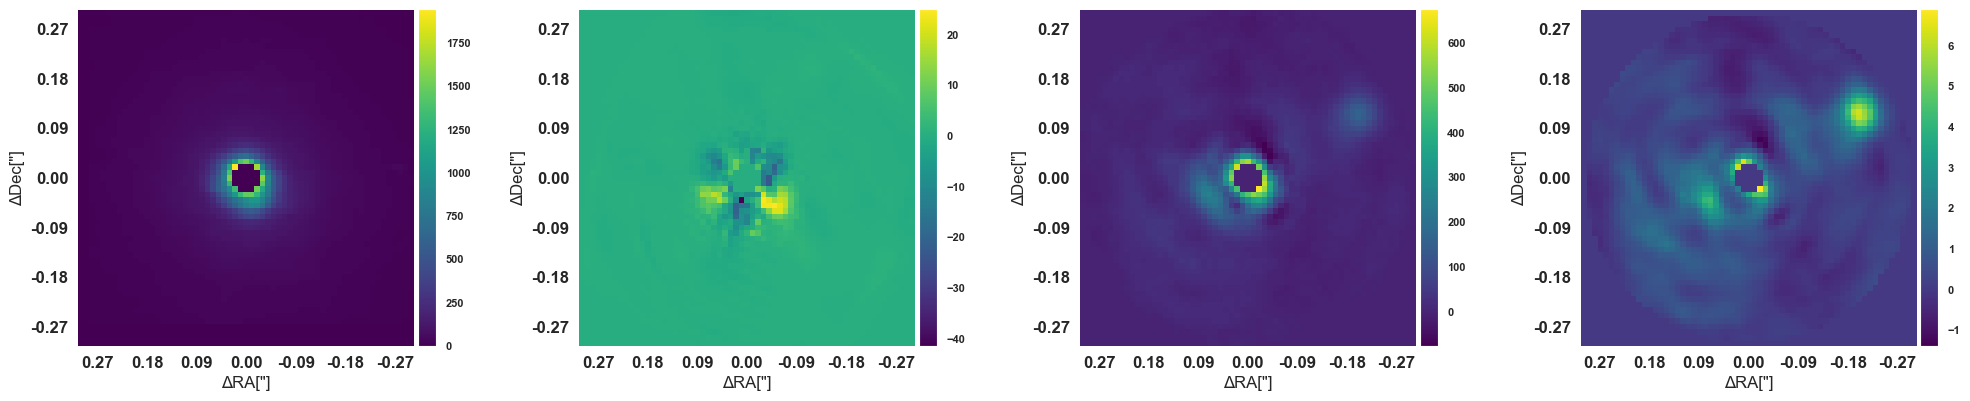

In [495]:
plot_frames((mask_circle(np.median(fake_comp_cube[50,:,:,:],axis=0),radius=2.5),
             mask_circle(med_med,radius=2.5),
             mask_circle(ccf_cube[:,:,10],radius=2.5),
             mask_circle(stim_map(derot_cubes[:,:,:,10]),radius=2.5)),
            rows = 1,ang_scale=True, ndec=2,ang_ticksep=9,log=False)

## Checking velocity

In [23]:
plt.plot(vels,ccf)
#plt.plot(vels[190:210],ccf[190:210])

NameError: name 'ccf' is not defined

In [138]:
def Gauss(x, a,mu,sigma):
    y = a*np.exp(-(x-mu)**2/(2*sigma**2))
    return y
parameters, covariance = curve_fit(Gauss, vels, ccf)
  
ccf_fit = Gauss(vels,*parameters)
ccf_manual =Gauss(vels,np.max(ccf),0,45.0)

/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [123]:
parameters

array([1., 1., 1.])

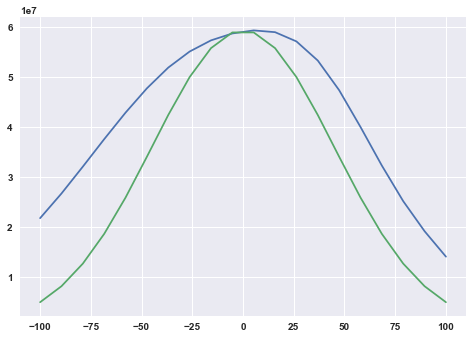

In [139]:
plt.plot(vels,ccf)
plt.plot(vels,ccf_manual)

In [282]:
help(CC.compareFluxes)

NameError: name 'CC' is not defined

## Matched filtering and STCM



In [479]:
ccf_cubes =[]
for i in range(83):
    file_name="/mnt/disk12tb/Users/rakesh/SpatialDetection/Testing_vel/Training_vel/ccf_cont_5e-04_rad_23.0_theta_60.00_frame_{0:02d}.fits".format(i)
    ccf_cubes.append(open_fits(file_name,verbose = False))

In [480]:
np.asarray(ccf_cubes).shape

(83, 61, 61, 20)

In [481]:
ccf_cubes = np.asarray(ccf_cubes)
derot_cubes = np.zeros(ccf_cubes.size).reshape(83,61,61,20)
inv_rot = np.zeros_like(derot_cubes)
for i in range(20):
    derot_cubes[:,:,:,i] = cube_derotate(ccf_cubes[:,:,:,i],angle_list=-rot_angles)
    inv_rot[:,:,:,i] = cube_derotate(ccf_cubes[:,:,:,i],angle_list=rot_angles)
    
ccf_cube = np.median(derot_cubes,axis =0)


In [404]:
rad = np.float(file_name.split("/")[-1].split('_')[4])
theta = np.float(file_name.split("/")[-1].split('_')[6])

y = 30.0 + rad*np.sin(np.deg2rad(theta))
x = 30.0 + rad*np.cos(np.deg2rad(theta))
mask = create_circular_mask(61,61,center=(30,30),radius= 3.5)

In [405]:
frames =[]
vels = np.linspace(-100,100,21)
for i in range(5,14):
    frames.append(ccf_cube[:,:,i])
for i in range(len(frames)):
    frames[i][mask] = 0
framep = tuple(frames)
#v=
vel_label = ['$v=$'+str(item)+" km/s" for item in vels[5:14]]
plot_frames(framep,rows=5,ang_ticksep=9,ang_scale=True,label=tuple(vel_label),ndec=2,
            colorbar=True,circle =(y,x ),
           circle_radius=2.5,
            save="/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_06.11.2022/CompanionCCF_r_{0:3.1f}_theta_{1:3.1f}_1e-03.png".format(rad,theta))

`Pixel scale set to 0.01`


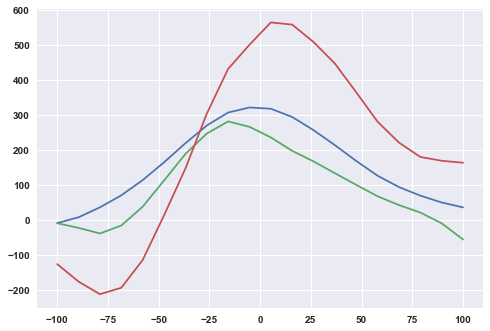

In [397]:
vels = np.linspace(-100,100,20)
plt.plot(vels,ccf_cube[int(x),int(y),:])
plt.plot(vels,ccf_cube[int(x+10),int(y-28),:])
plt.plot(vels,ccf_cube[28,33,:])

In [54]:
frame = ccf_cube[:,:,2]
frame = mask_circle(frame,radius=1.5)
vel_label = ['$v=$'+str(item)+" km/s" for item in vels[2:3]]
plot_frames((frame),rows=2,ang_ticksep=9,ndec=2,colorbar=True,circle =(y,x),circle_radius=2.4,
            save="/mnt/diskss/home/rnath/Monday_meetings/Plots_26.09.2022/ccfmap.png")

In [59]:
stim_map_25 = stim_map(np.median(derot_cubes[:,:,:,:],axis =-1))
#stim_map_25[mask] =0
stim_map_25 = mask_circle(stim_map_25,radius=3.5)

In [47]:
inverse_stim_25 = stim_map(np.median(inv_rot[:,:,:,:],axis=-1))
inverse_stim_25[mask] =0

In [889]:
norm_stim_25 = stim_map_25/np.nanmax(inverse_stim_25)

In [63]:
plot_frames((stim_map_25),
            #label = ('STCM for $r\\approx0.27$','Inverse STCM for $r\\approx0.27$'),
                     rows =2,
           ang_scale = False,
           ang_ticksep=9,
           save = "/mnt/diskss/home/rnath/Monday_meetings/Plots_26.09.2022/stcm_maps.png")
           #dpi = 400)

In [305]:
thr_stim_8 = norm_stim_8.copy()
thr_stim_8[norm_stim_8<1]=0
thr_stim_25 = norm_stim_25.copy()
thr_stim_25[norm_stim_25<1]=0
plot_frames((thr_stim_8,thr_stim_25),
           ang_scale =True,
           ang_ticksep=9,
           label = ('Thresholded STCM $r\\approx 0.09$, $C=10^{-3}$','Thresh. STCM $r\\approx 0.27$, $C=5\\times10^{-4}$'),
           save = '/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_18.07.2022/thresholded_STCM_diffcontrasts.png',
           dpi = 400)

`Pixel scale set to 0.01`


## Making patches

In [435]:
prefix = "/mnt/disk12tb/Users/rakesh/SpatialDetection/Training_vel/Training/H1patches/"
h1_patches = open_fits(prefix+"H1_seq_training_cont_1e-03_rad_22.0_theta_120.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (83, 20, 11, 11)


In [ ]:
plot_frames(tuple(np.median(h1_patches[0:83:10,:,:,:],axis=1)), 
            rows =5,
            ang_scale=True,
            ang_ticksep=5,
            colorbar=False)#,
          # save = "/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_06.11.2022/patches_h1_1e-03_smaller.png")
            #dpi = 600
           #)

In [456]:
vels = np.arange(-100,100,20)
vel_labs = tuple(["v= {0:1.1f} km/s".format((v)) for v in vels])
plot_frames(tuple(np.median(h1_patches[:,0:20:2,:,:],axis=0)), 
            rows =5,
            ang_scale=True,
            ang_ticksep=5,
            colorbar=True,
            label=vel_labs,
            save = "/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_06.11.2022/patches_h1_1e-03_vel.png")
#            dpi = 600)

`Pixel scale set to 0.01`


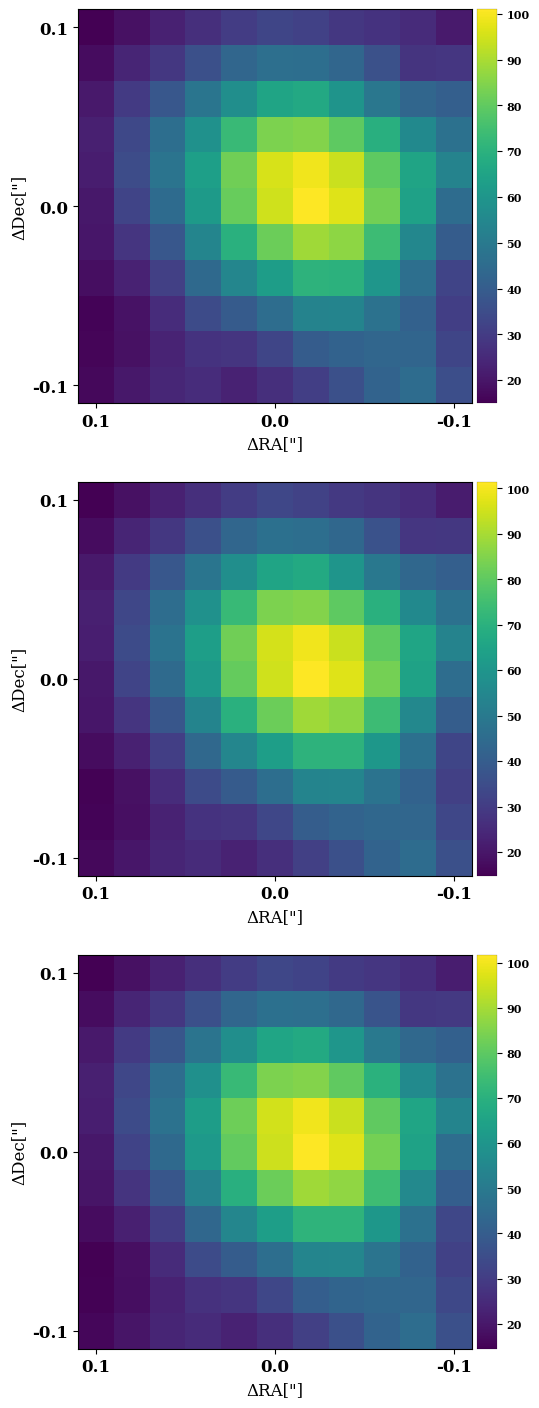

In [122]:
plot_frames(tuple(np.mean(h1_patches[0:83,:,:,:],axis =0)), 
            rows =4,
            ang_scale=True,
            ang_ticksep=5,
            colorbar=True)
            #save = "/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_18.07.2022/patches_h1_5e-04_smaller_highres.png",
            #dpi = 600
           #)

In [410]:
h0_patches = open_fits("/mnt/disk12tb/Users/rakesh/SpatialDetection/Data/H0patches_fov11/H0_patches_83frames.fits")

Fits HDU-0 data successfully loaded. Data shape: (36, 83, 3, 11, 11)


In [419]:
plot_frames(tuple(h0_patches[10,0:83:10,2,:,:]), 
            rows =5,
            ang_scale=True,
            ang_ticksep=12,
            colorbar= True,
            save = "/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_06.11.2022/patches_h0_smaller.png")
            #dpi =600
          # )

`Pixel scale set to 0.01`


In [111]:
h1_offcenter =  open_fits("/mnt/disk12tb/Users/rakesh/SpatialDetection/Data/H1patches_LCfov11/augment_H1_x_1_y_4_cont_1e-03_rad_11.0_theta_0.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (83, 3, 11, 11)


In [417]:
plot_frames(tuple(h1_offcenter[0:83:10,2,:,:]), 
            rows =4,
            ang_scale=True,
            ang_ticksep=12,
            colorbar= False)
          # save = "/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_18.07.2022/patches_h1_smaller_offcenter.png",
           # dpi =600)

NameError: name 'h1_offcenter' is not defined

# Results

## SNR results

In [53]:
samples =[]
locs=[]
for ang in [90,120,330,360]:
    filename = "/mnt/disk12tb/Users/rakesh/SpatialDetection/MedianCCF/CCF_median_analysis_PC/ccf_cont_1e-04_rad_21.0_theta_{0:3.2f}_PC_1.fits".format(ang)
    sample = open_fits(filename)
    rad = np.float(filename.split("/")[-1].split('_')[4])
    theta = np.float(filename.split("/")[-1].split('_')[6].split('.')[0])

    y = 30.0 + rad*np.sin(np.deg2rad(theta))
    x = 30.0 + rad*np.cos(np.deg2rad(theta))
    locs.append([y,x])
    samples.append(sample)

Fits HDU-0 data successfully loaded. Data shape: (61, 61, 5)
Fits HDU-0 data successfully loaded. Data shape: (61, 61, 5)
Fits HDU-0 data successfully loaded. Data shape: (61, 61, 5)
Fits HDU-0 data successfully loaded. Data shape: (61, 61, 5)


In [54]:
rad = np.float(filename.split("/")[-1].split('_')[4])
theta = np.float(filename.split("/")[-1].split('_')[6].split('.')[0])

y = 30.0 + rad*np.sin(np.deg2rad(theta))
x = 30.0 + rad*np.cos(np.deg2rad(theta))

In [55]:
snmaps=[]
for sample in samples:
    snmap =snrmap(sample[:,:,2],fwhm =4.8)
    snmaps.append(snmap)
#snmap[y,x]

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-09-20 14:21:38
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:00.808130
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-09-20 14:21:38
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:00.725222
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-09-20 14:21:39
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:00.636131
――――――――――――――――――――――――――――――――――――――――――――――――――――

In [56]:
normalized_maps=[]
truth_maps=[]
for i in range(len(snmaps)):
    temp = snmaps[i]
    temp = (temp -temp.min())/(temp.max()-temp.min())
    normalized_maps.append(np.ravel(temp))
    tmap = np.zeros_like(temp)
    tmap = mask_circle(tmap,radius=2.5,fillwith=1,mode='in',cy=locs[i][1],cx=locs[i][0])
    truth_maps.append(np.ravel(tmap))


In [39]:
truths = np.ravel(np.asarray(truth_maps))
preds = np.ravel(np.asarray(normalized_maps))

In [40]:
normalized_maps[0]

array([0.3829859, 0.3829859, 0.3829859, ..., 0.3829859, 0.3829859,
       0.3829859], dtype=float32)

In [32]:
locs_labs =[tuple(l) for l in locs]

In [23]:
locs_labs=tuple(locs_labs)

In [33]:
snmaps[0].shape

(61, 61)

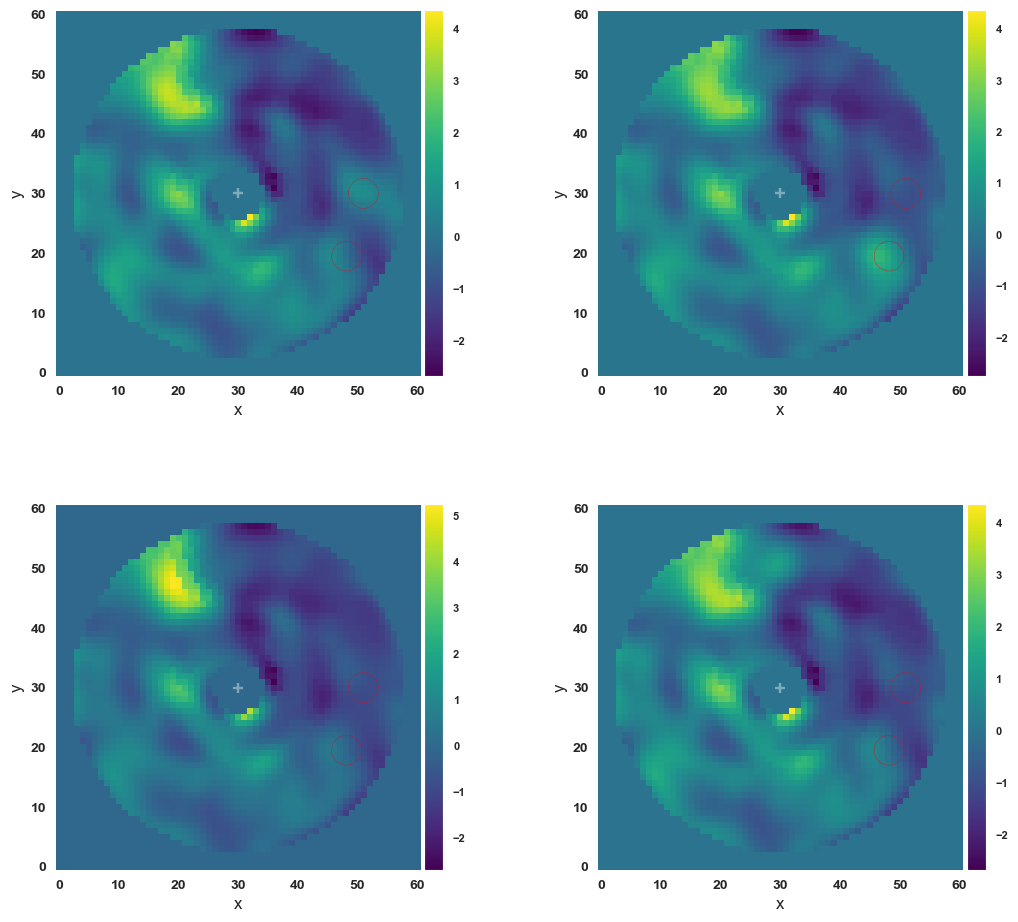

In [57]:
plot_frames(tuple(snmaps),show_center=True,rows=2,circle=tuple(locs_labs),circle_radius=2.5,circle_color='r')

`Size` is even (while input frame size is odd). Setting `size` to 11 pixels
New shape: (11, 11)


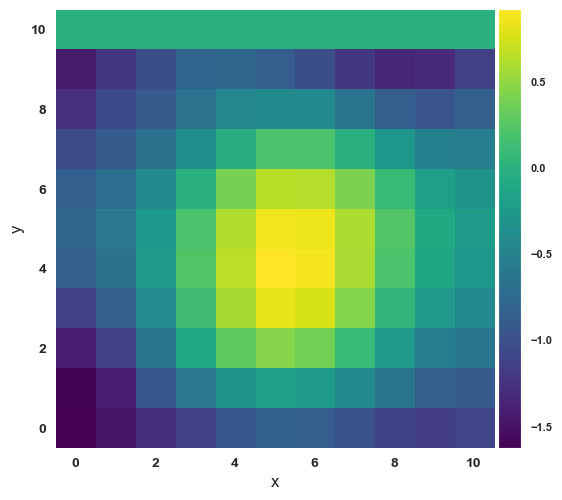

In [3741]:
plot_frames(frame_crop(snmaps[0],cenxy=locs[0],size=10))

In [366]:
help(snrmap)

Help on function snrmap in module vip_hci.metrics.snr_source:

snrmap(array, fwhm, approximated=False, plot=False, known_sources=None, nproc=None, array2=None, use2alone=False, exclude_negative_lobes=False, verbose=True, **kwargs)
    Parallel implementation of the S/N map generation function. Applies the
    S/N function (small samples penalty) at each pixel.
    
    The S/N is computed as in [MAW14]_ for each radial separation.
    
    **DISCLAIMER**:
    Signal-to-noise ratio is not significance! For a conversion from SNR to
    n-sigma (i.e. the equivalent confidence level of a Gaussian n-sigma), use
    the ``significance`` function.
    
    
    Parameters
    ----------
    array : numpy ndarray
        Input frame (2d array).
    fwhm : float
        Size in pixels of the FWHM.
    approximated : bool, optional
        If True, an approximated S/N map is generated.
    plot : bool, optional
        If True plots the S/N map. False by default.
    known_sources : None, tuple 

### ROC for snr

In [58]:
#max_blobs=np.arange(5,1,-0.4)
res = compute_binary_map(snmaps[0],thresholds=np.linspace(2.0,np.max(snmaps[0])-0.7,10)
                         ,injections=locs[-2],fwhm=4.8,max_blob_fact=4)

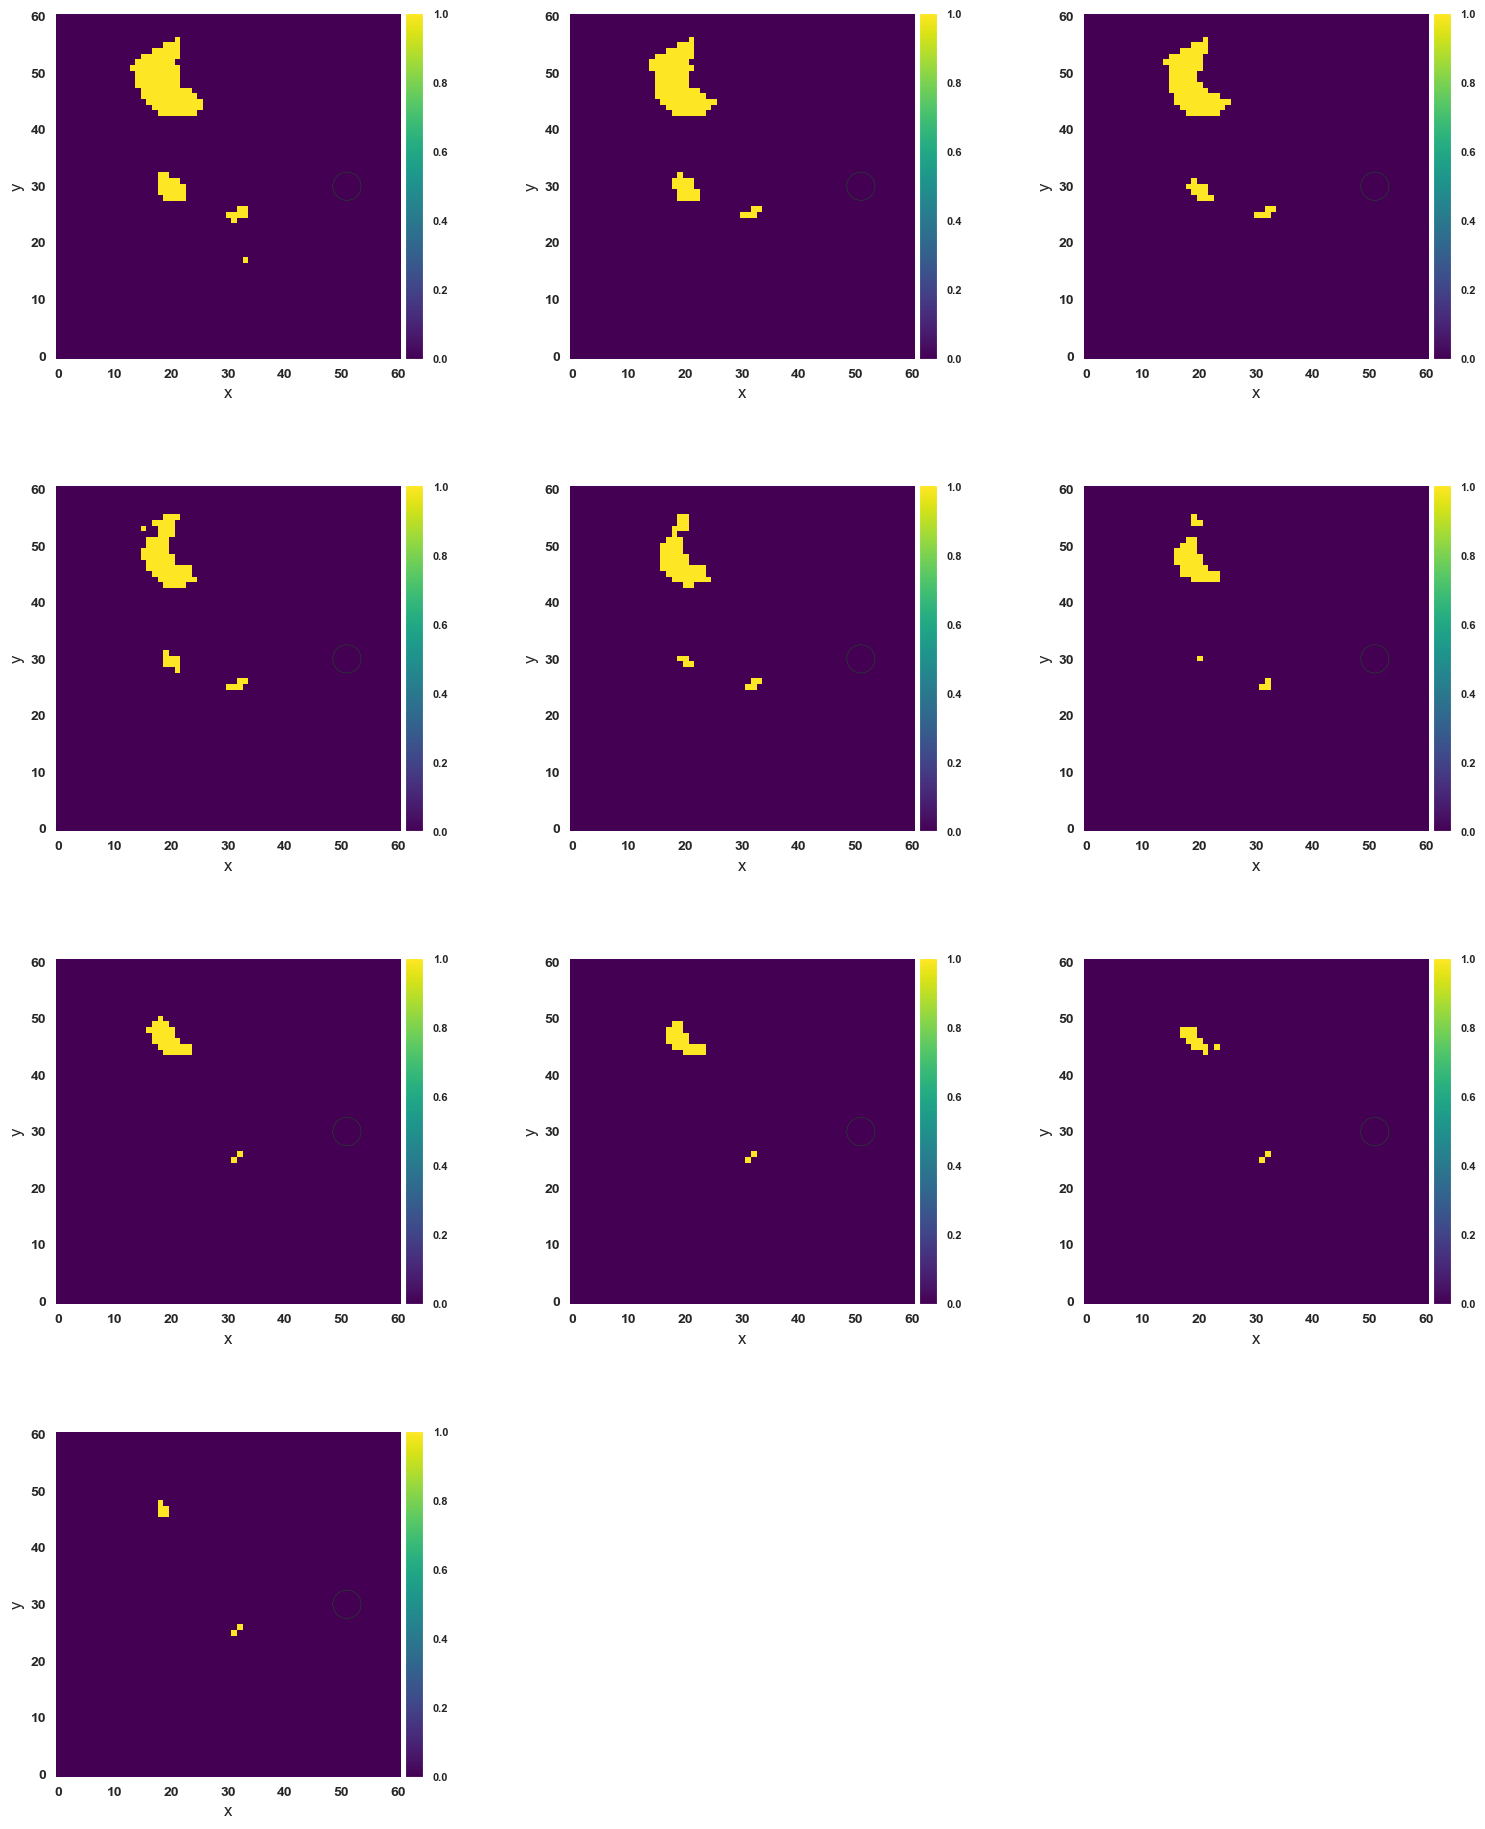

In [59]:
plot_frames(tuple(res[2]),rows=4,circle=tuple(locs[0]),circle_radius=2.5,circle_color='green')

In [563]:
res[0],res[1]

([1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [6, 6, 6, 6, 6, 6, 2, 2, 3, 3])

In [60]:
len_thresholds =10
total_fps = np.zeros(len_thresholds)
total_tpf = np.zeros(len_thresholds)
min_maps =[]
binmaps_snr=[]
results=[]
thresholds=np.linspace(2.0,max_val,len_thresholds)
for i in range(len(snmaps)):
    max_val = np.max(snmaps[i]-1e-04)
    res=compute_binary_map(snmaps[i],
                           thresholds=np.linspace(2.0,max_val,len_thresholds),injections=locs[i],
                           fwhm=4.8,max_blob_fact=2,overlap_threshold=0.7,npix=1)
    binmaps_snr.append(res[2])
    tpf =res[0]
    fpf =res[1]
    results.append(res)
    for i in range(len(thresholds)):
        if(tpf[i]>1):
            temp = tpf[i]-1
            fpf[i] =fpf[i]+temp
            tpf[i] =1
            
    total_tpf = total_tpf+np.asarray(tpf)
    total_fps = total_fps+np.asarray(fpf)

In [66]:
max_val

4.342263

In [63]:
binmaps_snr=np.asarray(binmaps_snr)

In [64]:
binmaps_snr.shape

(4, 10, 61, 61)

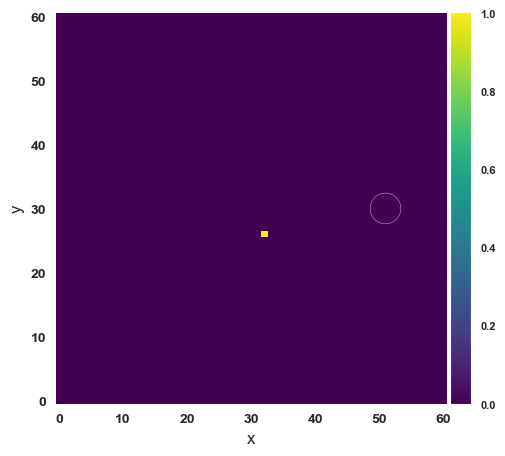

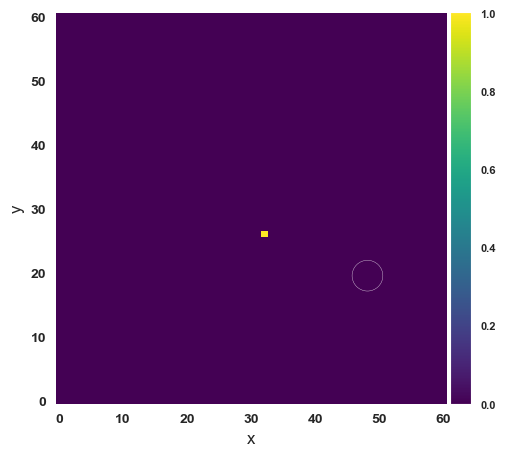

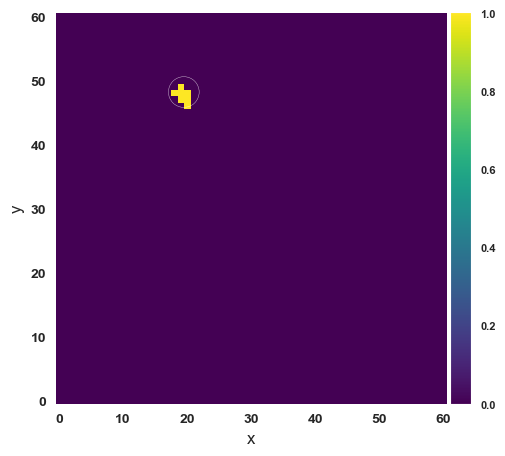

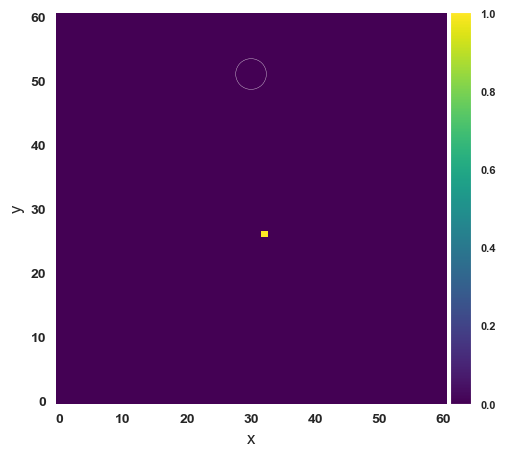

In [65]:
for i in range(len(binmaps_snr)):
    plot_frames((binmaps_snr[i,-2,:]),rows=5,circle=tuple(locs[i]),circle_radius=2.4)

In [3262]:
locs_int[0]

(41.0, 30.0)

In [61]:
total_tpf/len(snmaps),total_fps/len(snmaps)

(array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]),
 array([3.  , 2.75, 3.5 , 3.25, 4.5 , 3.  , 2.5 , 1.5 , 0.75, 0.75]))

In [3264]:
len(snmaps)

12

In [3743]:
actual_tpf=np.zeros_like(total_tpf)
for i in range(len(total_tpf)):
    if((total_tpf[i]-len(snmaps))>0):
        actual_tpf[i]=1.0
        print(total_tpf[i]-len(snmaps))
        total_fps[i] =total_fps[i]+(total_tpf[i]-len(snmaps))
    else:
        actual_tpf[i] = total_tpf[i]/len(snmaps)
    

In [361]:
total_fps,actual_tpf

NameError: name 'actual_tpf' is not defined

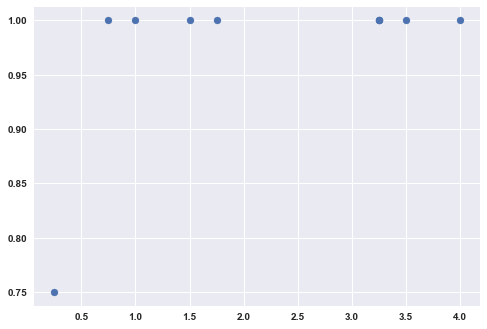

In [52]:
plt.scatter(total_fps[::]/len(snmaps),total_tpf[::]/len(snmaps))


## STCM results

In [3229]:
masked_psf = mask_circle(psf_template,radius=4.5,mode='out')

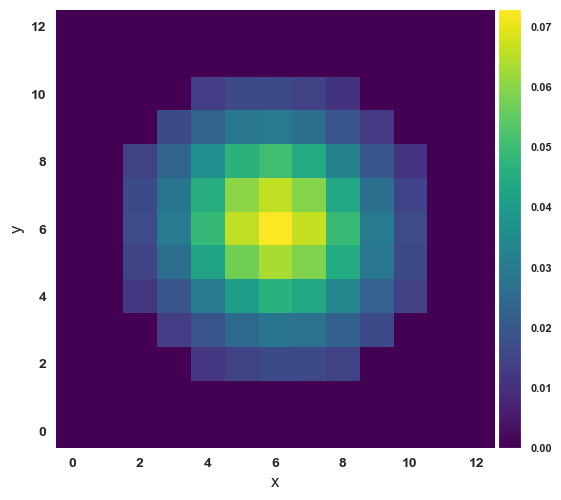

In [3230]:
plot_frames((np.median(masked_psf,axis=0)))

In [233]:
angles_chosen =[0.00,30.00,60.00,90.00,120.00,150.00,180.00,210.00,240.00,270.00,300.00,330.00]
#samples = np.zeros(3*61*61).reshape(3,61,61)
len_sequence = 83
samples_stim = np.zeros(len(angles_chosen)*len_sequence*61*61).reshape(len(angles_chosen),len_sequence,61,61)
noise_stim = np.zeros_like(samples_stim)
arrows =[]
#psf_mask= np.median(masked_psf,axis=0)

for ang in range(len(angles_chosen)):
    #prefix = "/mnt/disk12tb/Users/rakesh/SpatialDetection/Data/CCF_individual_slices_truncatedpsf/"
    prefix = "/mnt/disk12tb/Users/rakesh/SpatialDetection/Data/"
    fits_files=[]
    for i in range(len_sequence):
        fname = prefix+"ccf_cont_3e-04_rad_23.0_theta_{0:3.2f}_frame_{1:02d}.fits".format(angles_chosen[ang],i)
        f = open_fits(fname,
                      verbose=False)
        rad = np.float(fname.split("/")[-1].split('_')[4])
        theta = np.float(fname.split("/")[-1].split('_')[6].split('.')[0])

        #y = 30.0 + rad*np.sin(np.deg2rad(theta))
        #x = 30.0 + rad*np.cos(np.deg2rad(theta))
        y_mod = 30.0 + rad*np.sin(np.deg2rad(theta-rot_angles[i]))
        x_mod = 30.0 + rad*np.cos(np.deg2rad(theta-rot_angles[i]))
       
        #cropped_frame = frame_crop(f[:,:,2],size=11,cenxy=(y_mod,x_mod),verbose=False)
        #crop_mask = mask_circle(cropped_frame,radius=2.2,mode='out')
        #f_mask = mask_circle(f[:,:,2],radius=5.5,mode='in',cx=y_mod,cy=x_mod)
        #f_mask[int(x_mod)-5:int(x_mod)+6,int(y_mod)-5:int(y_mod)+6] =crop_mask
        #f_masked = convolve2d(f[:,:,2],psf_mask,mode='same')
       
       
        fits_files.append(f[:,:,2])
    #print(len(fits_files))
    fits_files = np.asarray(fits_files)
    rad = np.float(fname.split("/")[-1].split('_')[4])
    theta = np.float(fname.split("/")[-1].split('_')[6].split('.')[0])

    y = 30.0 + rad*np.sin(np.deg2rad(theta))
    x = 30.0 + rad*np.cos(np.deg2rad(theta))

    arrows.append([y,x])
    f2 = cube_derotate(fits_files,angle_list=-rot_angles)
    f_noise = cube_derotate(fits_files,angle_list=rot_angles)
    samples_stim[ang,:,:,:] = f2
    noise_stim[ang,:,:,:] = f_noise
    
        
        
    #samples[ang] = np.mean(f2,axis=0)
    

In [234]:
sigs =[]
threshmaps =[]
mask = create_circular_mask(61,61,center=(30,30),radius= 2.5)
signals=[]
noises =[]
signals_stim=[]
normalized_stims =[]
truth_stims=[]
for i in range(len(angles_chosen)):
    samples_stim[i] = mask_circle(samples_stim[i],radius=2.4,mode='in')
    signal_stim = stim_map(samples_stim[i])
    signal = np.mean(samples_stim[i],axis=0)
    noise = stim_map(noise_stim[i])
    #signal[mask] =0
    #noise[mask] =0
    #signal = mask_circle(signal,radius=2.24)
    #signal = mask_circle(signal,radius=2.2,cx=arrows[i][1],cy=arrows[i][0],mode='out')
    #noise = mask_circle(noise)
    print(np.max(signal)/np.nanmax(noise))
    sigs.append((np.max(signal)/np.nanmax(noise)))
    threshmaps.append(signal/np.nanmax(noise))
    signals.append(signal)
    signals_stim.append(signal_stim)
    noises.append(noise)
    normalized_maps=[]
    
    temp = signal_stim
    temp = (temp -temp.min())/(temp.max()-temp.min())
    normalized_stims.append(np.ravel(temp))
    tmap = np.zeros_like(temp)
    tmap = mask_circle(tmap,radius=2.5,fillwith=1,mode='in',cy=arrows[i][1],cx=arrows[i][0])
    truth_stims.append(np.ravel(tmap))



11.195298522315602
11.195294999165618
11.195302629517187
11.195298371592607
11.195293981785408
11.195317739497334
11.195294980325242
11.19529562089797
11.195297643098138
11.195292688079709
11.195296512675682
11.195289560577585


In [4431]:
truth_stim = np.ravel(np.asarray(truth_stims))
pred_stim = np.ravel(np.asarray(normalized_stims))

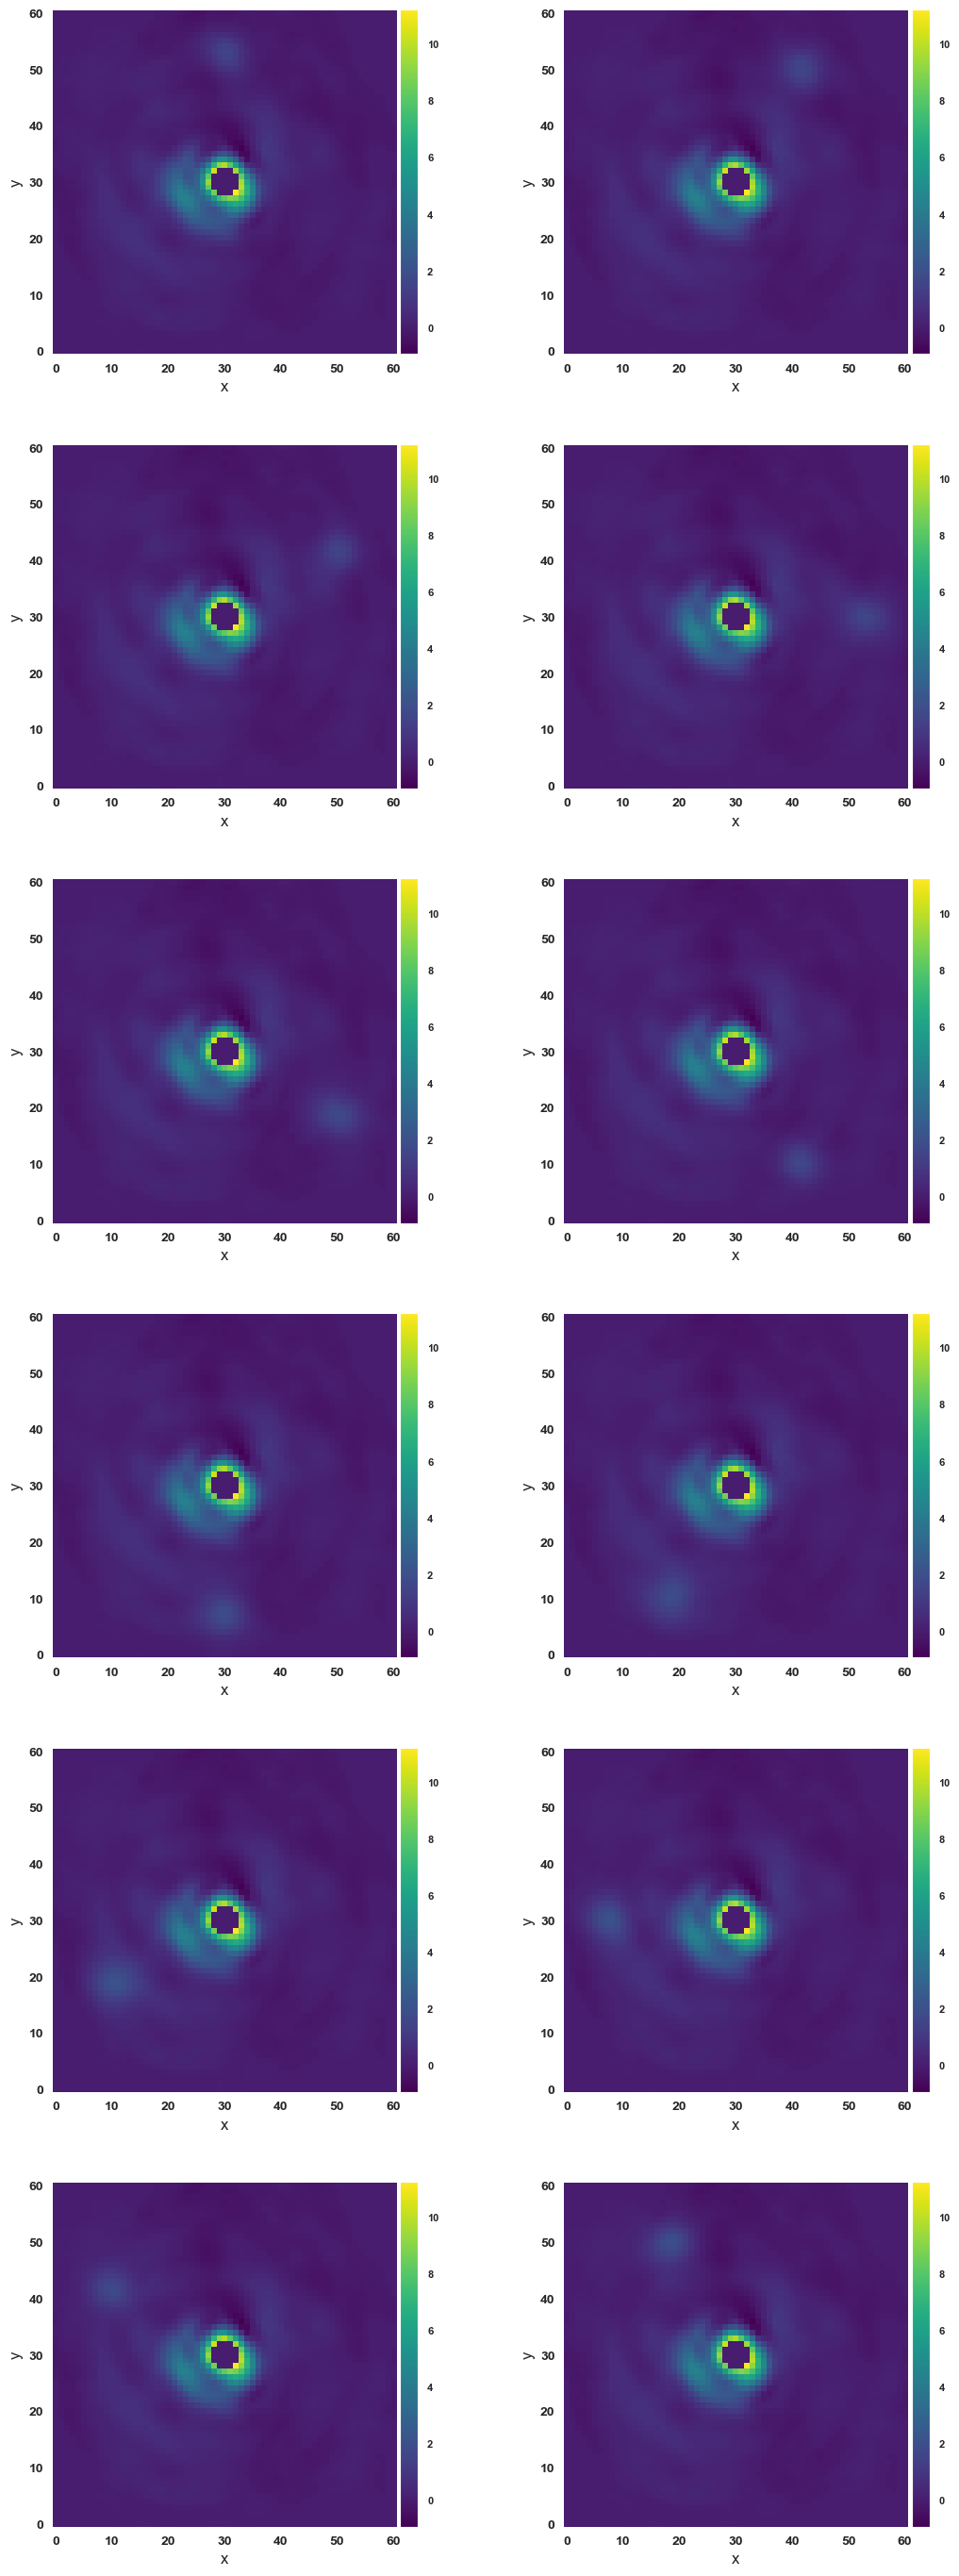

In [235]:
plot_frames(tuple(threshmaps),rows=10)

In [3114]:
arrows[0]

[30.0, 41.0]

In [3770]:
#tup = tuple((signal/np.nanmax(noise),signal,noise))
tup = tuple(threshmaps)
tup2 = tuple(signals)
tup3 =samples_stim[0,::]
#for t in range(4):
#plot_frames(tuple(tup3),rows =2,arrow=tuple(arrows[t]),vmin=1)


In [3577]:
#plot_frames(tuple(tup3[63:80]-np.mean(tup3,axis=0)),rows=5)

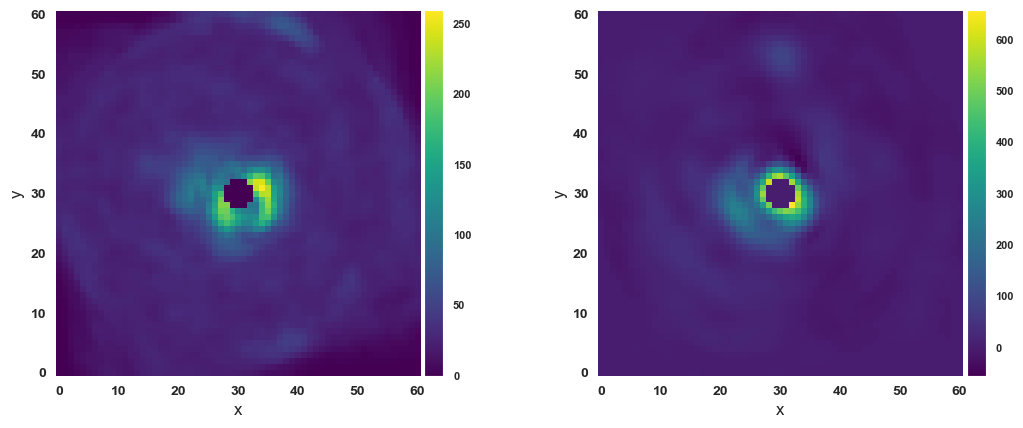

In [3771]:
plot_frames((np.std(tup3,axis=0),np.mean(mask_circle(tup3,radius=2.5),axis=0)))

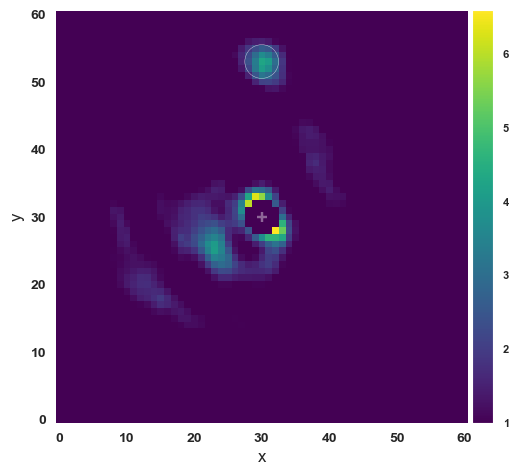

In [3772]:
plot_frames((mask_circle(signals_stim[0],radius=2.5)),rows =2,circle=tuple(arrows[t]),circle_radius=2.5,
            vmin=1,show_center=True)

In [3198]:
tup3.shape

(83, 61, 61)

New shape: (7, 7)


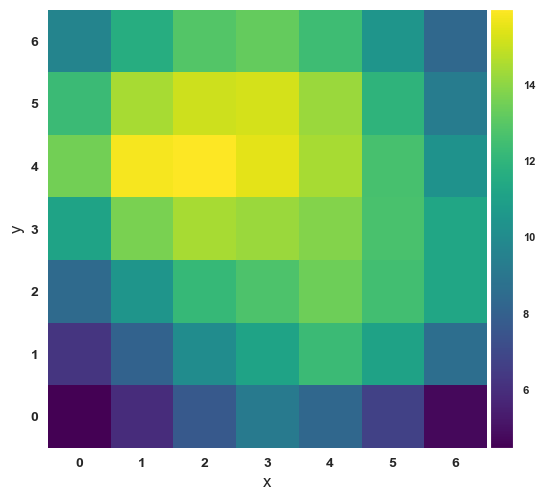

In [3535]:
plot_frames(frame_crop(signals_stim[0],cenxy=arrows[0],size=7))

### ROC for STCM


In [3817]:
binmaps = []
maxs=[]
results_stcm=[]

for i in range(len(signals_stim)):
    #sig = snrmap(signals[i],fwhm=4.8)
    maxs.append(np.max(signals_stim[i]))

thresholds = np.linspace(0,10,10)
tpfs_foronerad=np.zeros(len(thresholds))
fpf_foronerad=np.zeros(len(thresholds))
for i in range(len(signals)):
    thresholds = np.linspace(1.2,(maxs[i]-0.0001),10)
    tpf,fpf,bmp = compute_binary_map(signals_stim[i],thresholds=thresholds,injections=arrows[i]
                                     ,fwhm=5,overlap_threshold=0.7,npix=1,max_blob_fact=3)
    results_stcm.append([tpf,fpf,bmp])
    for i in range(len(thresholds)):
        if(tpf[i]>1):
            temp = tpf[i]-1
            fpf[i] =fpf[i]+temp
            tpf[i] =1
            
    tpfs_foronerad=tpfs_foronerad+tpf
    fpf_foronerad =fpf_foronerad+fpf
    binmaps.append(bmp)

In [3818]:
thresholds

array([1.2       , 1.7979124 , 2.39582481, 2.99373721, 3.59164961,
       4.18956201, 4.78747442, 5.38538682, 5.98329922, 6.58121162])

6.585076939192148

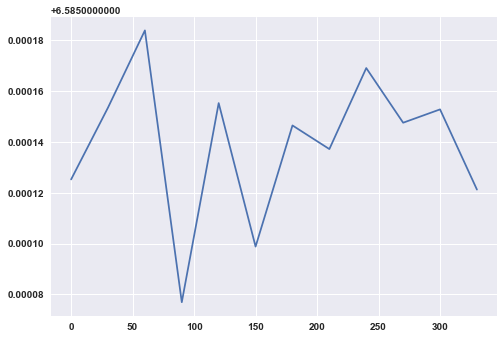

In [3407]:
plt.plot(angles_chosen,maxs)
np.min(maxs)

In [3203]:
binmaps[0][0].shape

(61, 61)

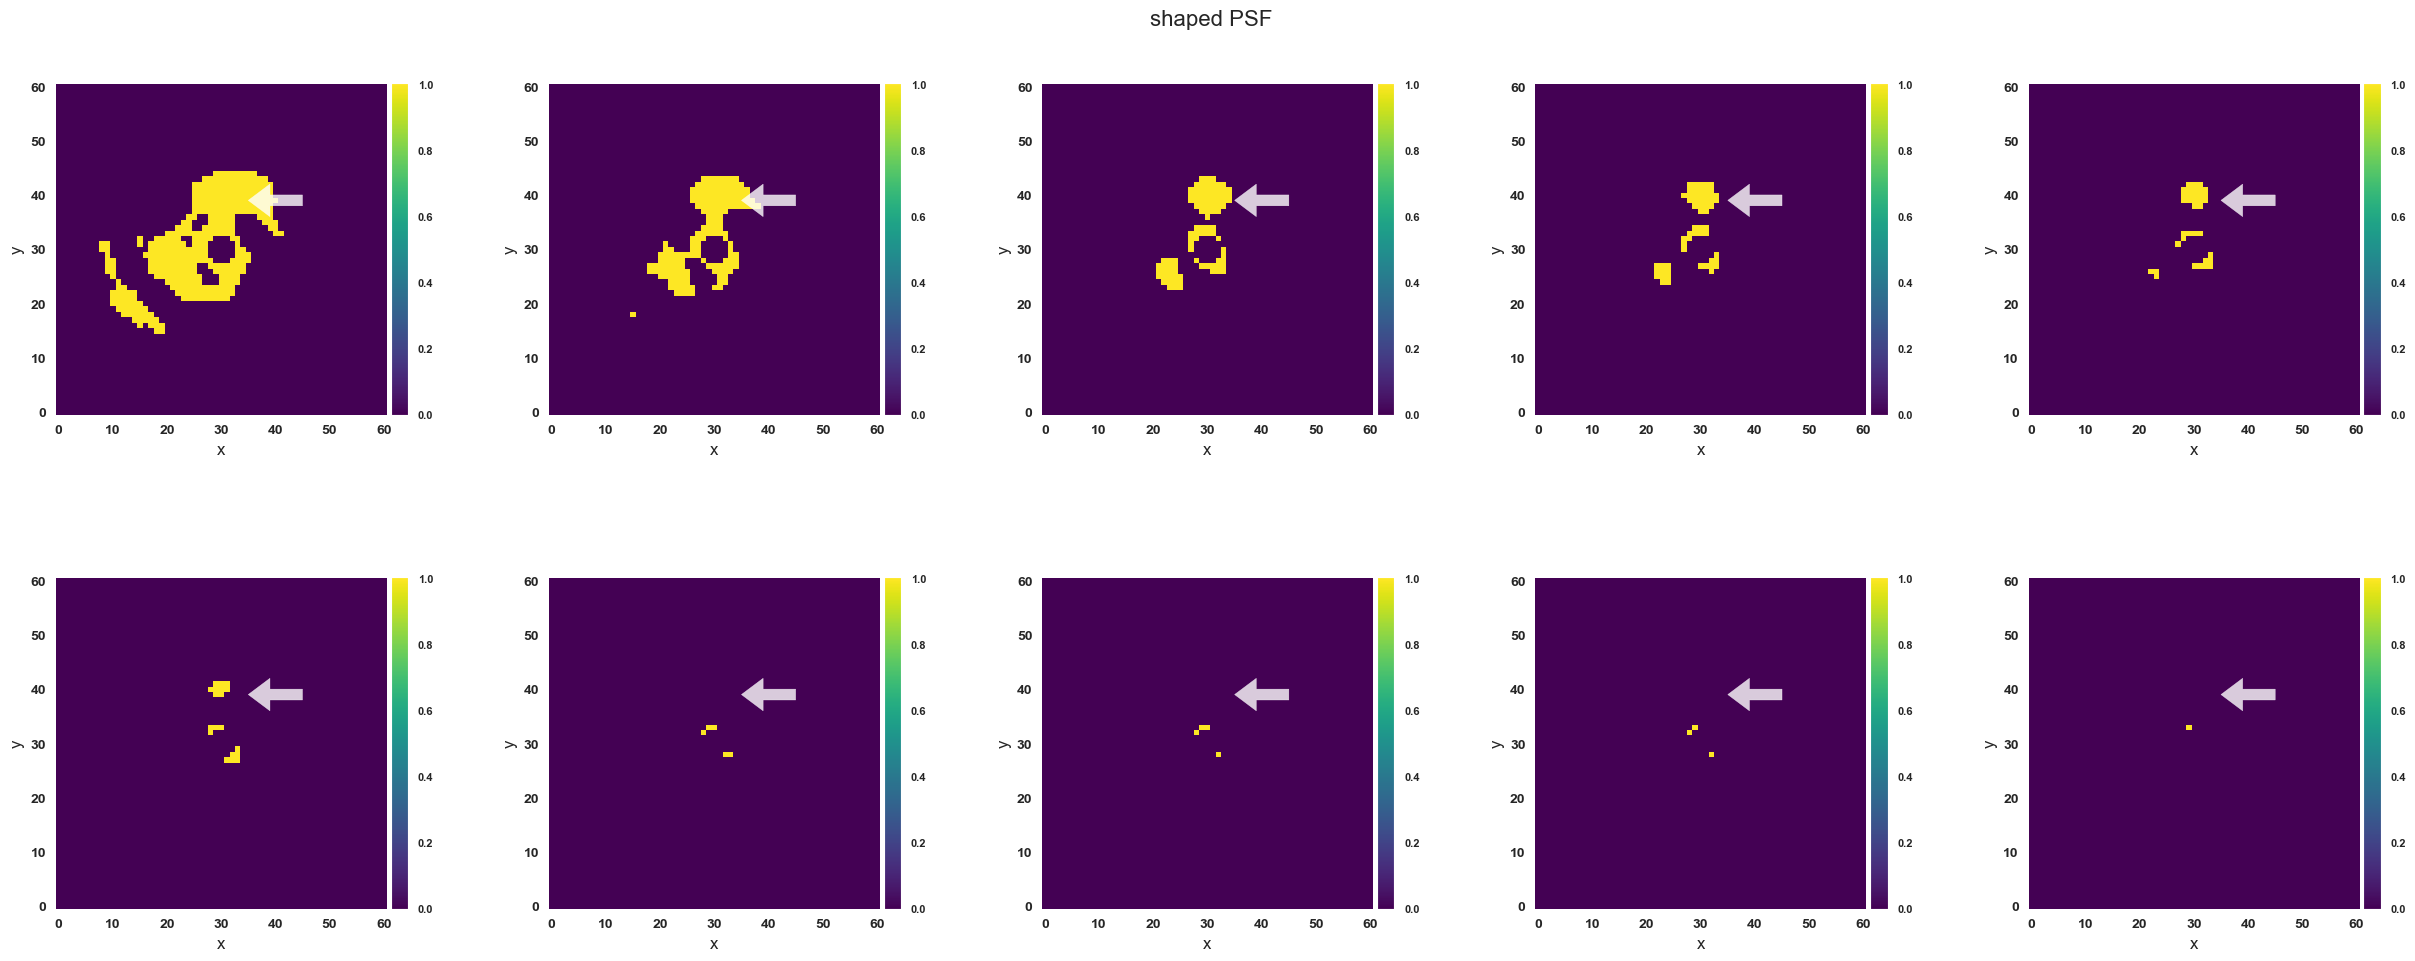

In [3491]:
plot_frames(tuple(binmaps[0]),arrow=tuple(arrows[0]),rows=2,title='shaped PSF')

In [3410]:
binmaps = np.asarray(binmaps)

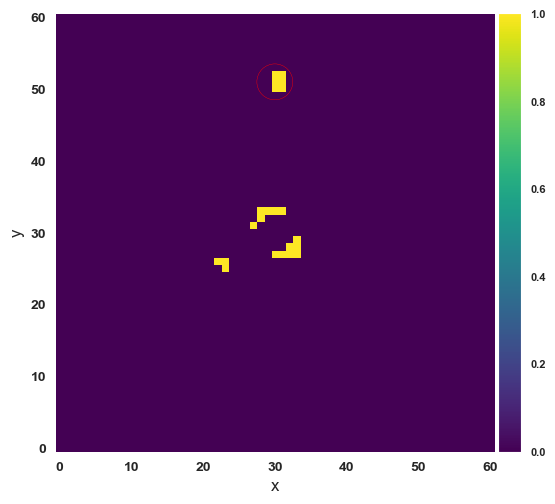

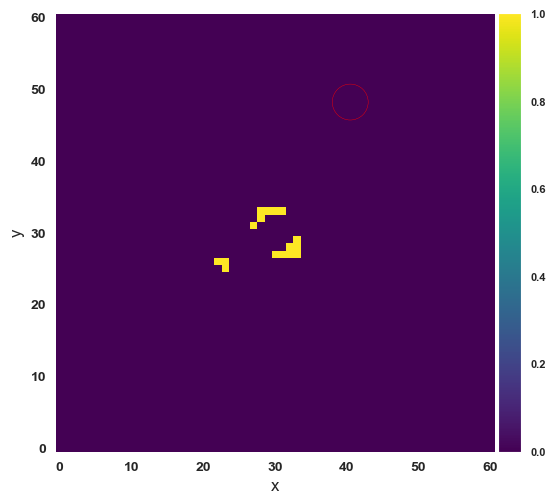

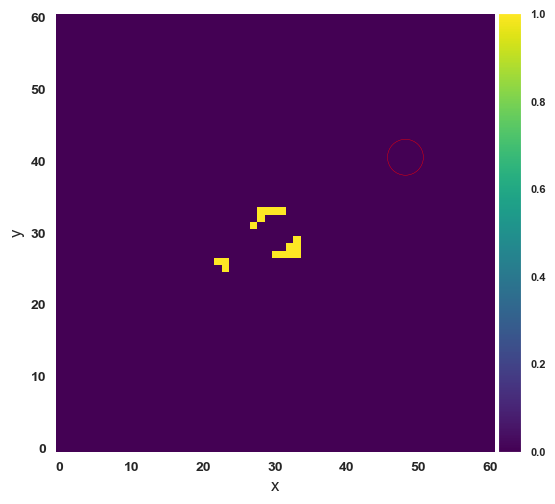

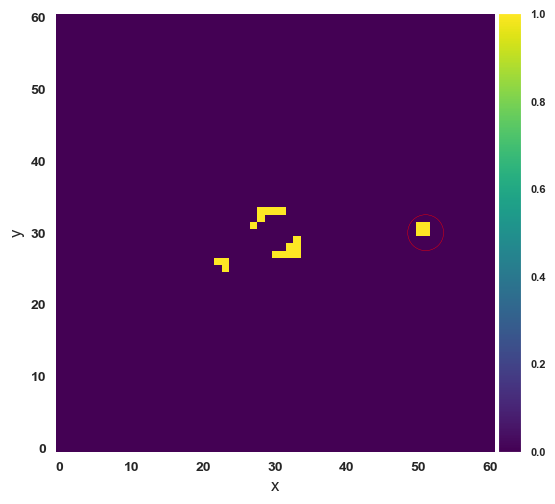

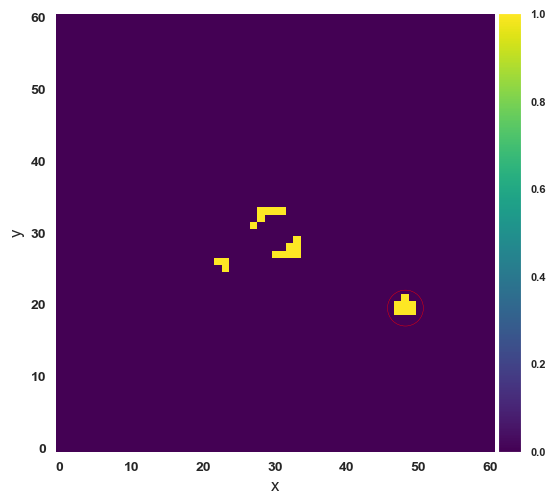

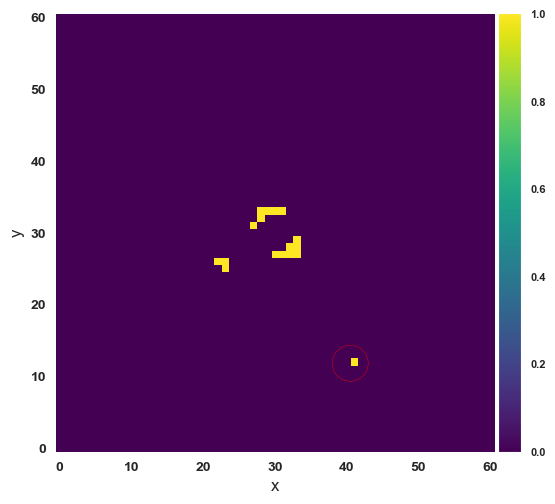

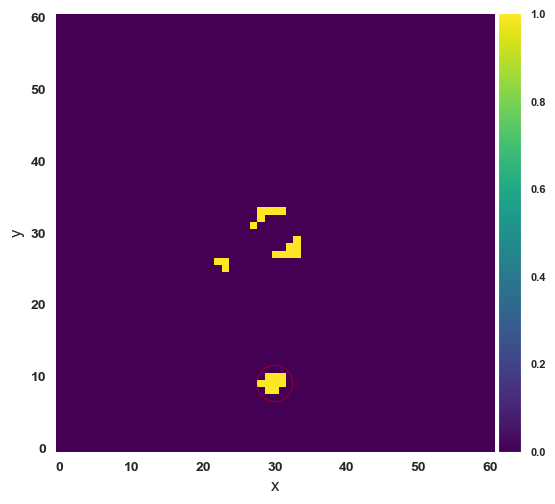

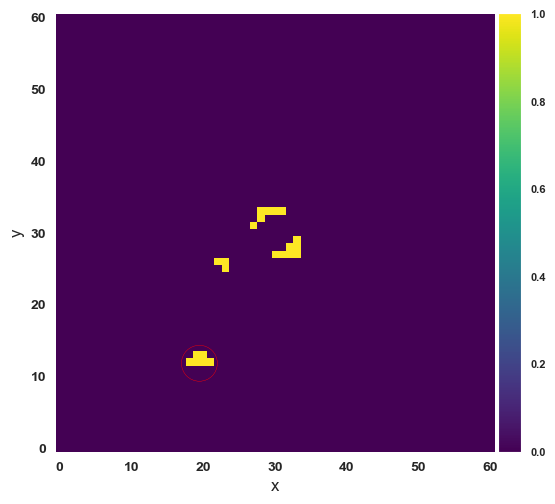

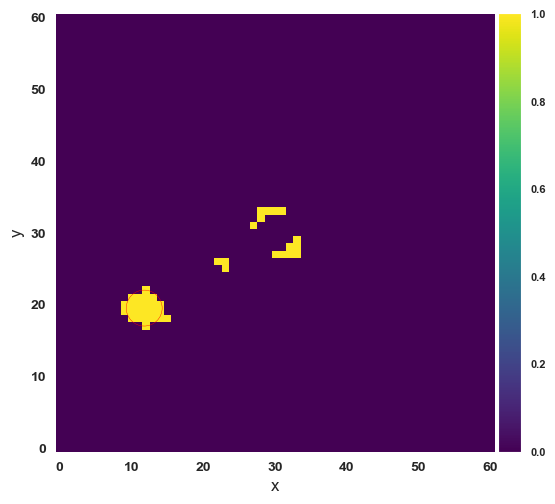

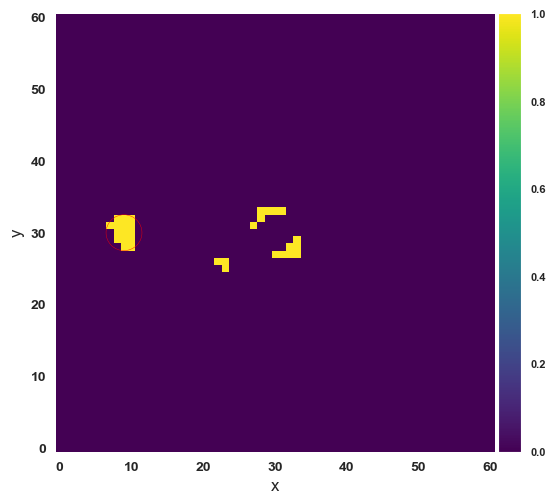

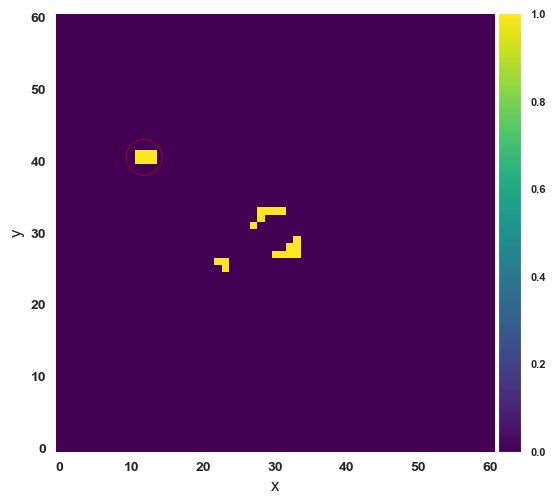

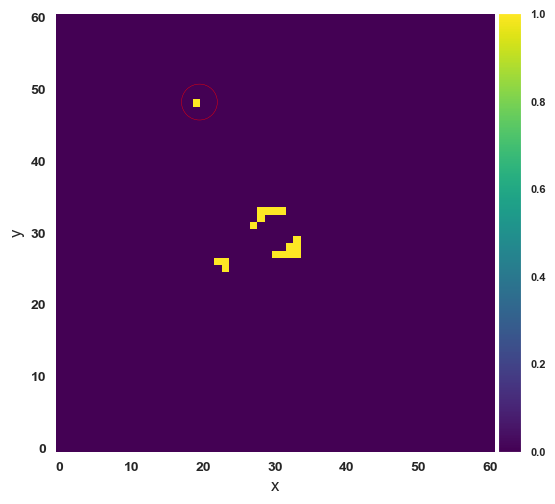

In [3411]:
for i in range(12):
    plot_frames(binmaps[i,4,:,:],circle=tuple(arrows[i]),circle_radius=2.5,circle_color='red',circle_alpha=1)

In [3819]:
tpfs_foronerad,fpf_foronerad,thresholds

(array([1., 8., 9., 7., 4., 2., 2., 1., 1., 0.]),
 array([74., 43., 57., 34., 45., 25., 36., 36., 32., 12.]),
 array([1.2       , 1.7979124 , 2.39582481, 2.99373721, 3.59164961,
        4.18956201, 4.78747442, 5.38538682, 5.98329922, 6.58121162]))

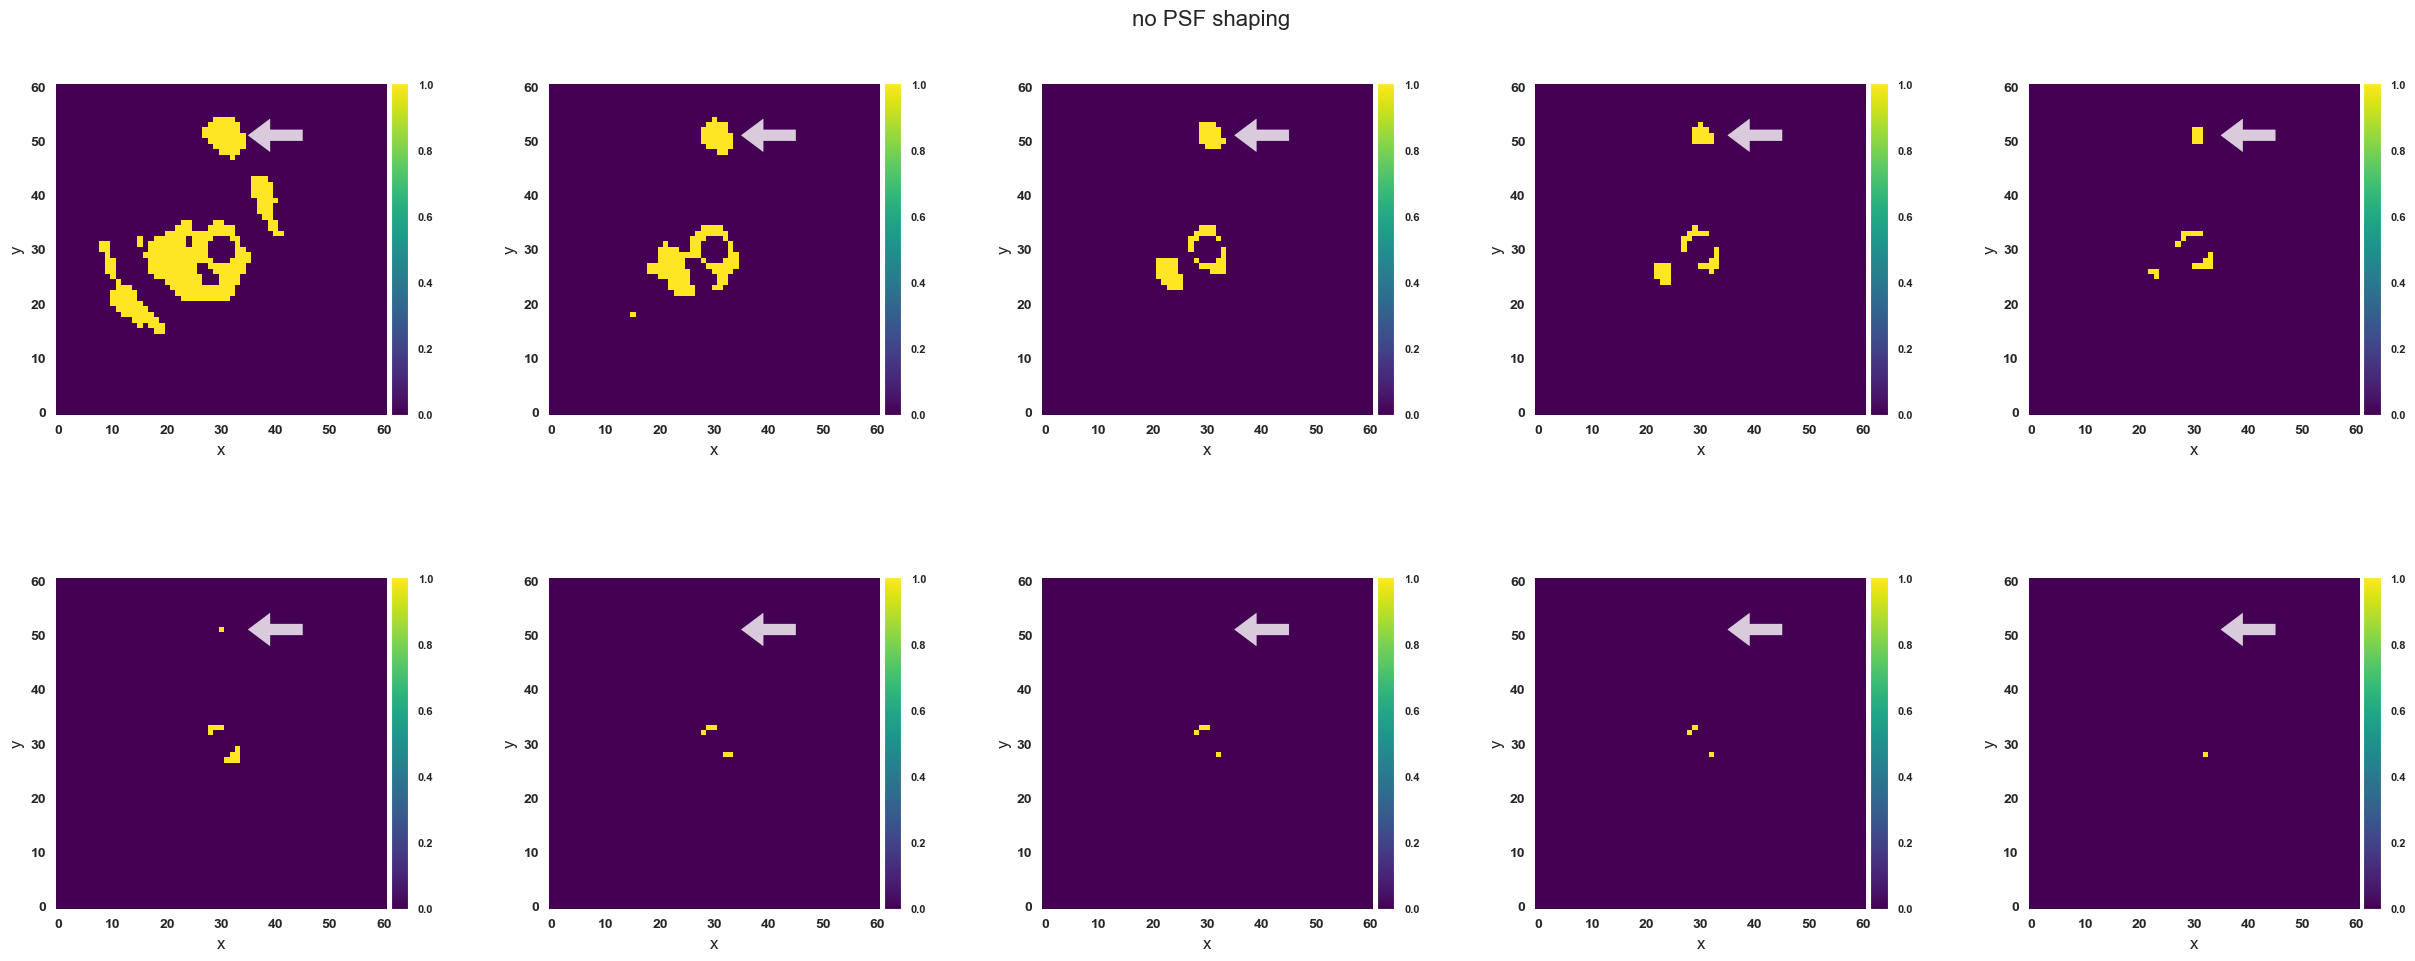

In [3413]:
plot_frames(tuple(binmaps[0]),arrow=tuple(arrows[0]),rows=2,title='no PSF shaping')

In [3693]:
tpfs_foronerad,fpf_foronerad,thresholds

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([58., 48., 60., 36., 48., 24., 36., 36., 36., 12.]),
 array([1.2       , 1.79833882, 2.39667764, 2.99501645, 3.59335527,
        4.19169409, 4.79003291, 5.38837172, 5.98671054, 6.58504936]))

In [3162]:
thresholds,fpf_foronerad[::],tpfs_foronerad

(array([1.2       , 1.79833936, 2.39667871, 2.99501807, 3.59335743,
        4.19169678, 4.79003614, 5.38837549, 5.98671485, 6.58505421]),
 array([69., 46., 58., 33., 46., 26., 36., 36., 36., 12.]),
 array([ 4.,  8., 12.,  7.,  6.,  5.,  1.,  1.,  0.,  0.]))

In [1450]:
#old_fpf =fpf_foronerad
#old_tpf = tpfs_foronerad
#diff_todetectfpf = fpf_foronerad
#diff_todetecttpf = tpfs_foronerad

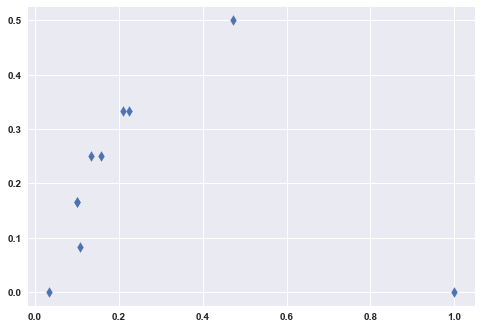

In [2970]:
ax= plt.gca()
plt.scatter(fpf_foronerad[::]/np.max(fpf_foronerad),tpfs_foronerad[::]/len(signals),marker='d')
#plt.scatter(old_fpf[::],old_tpf[::]/len(signals))
#ax.set_xscale('log')
#ax.set_yscale('log')
#plt.loglog(diff_todetectfpf,diff_todetecttpf[::]/len(signals))
#plt.axhline(0.5,ls='--',c='k')
#plt.axvline(1/3600.)

## ML results

In [3242]:
def compute_tpf_df(df,r,c):
    df_filt = df.loc[((df['Contrast']==c) & (df['R']==(r)) &(df['Nonaugmented'] == True)),['Predicted','Truth']]
    for i in range(len(df_filt)):
        if(df_filt['Predicted'].iloc[i]>0.5):
            df_filt['Predicted'].iloc[i] =1
        else:
            df_filt['Predicted'].iloc[i]=0
    print("C={0:1.0e},r ={1:3.1f}, predicted positives = {2:1.0f}/{3:1.0f} ".format(c,r,np.sum(df_filt['Predicted']),np.sum(df_filt['Truth'])))
    return np.sum(df_filt['Predicted'])/np.sum(df_filt['Truth'])
    

In [4437]:
RF = pd.read_excel("RF_training_HC.xlsx")#ends in HC
#RF = pd.read_excel("RF_training_HC_newdata.xlsx")
CNN = pd.read_excel("2dcnn_test_hc_reduced.xlsx")#ends in hc_reduced
#CNN = pd.read_excel("2dcnn_test_hc_nonaug_newdata.xlsx")
LSTM = pd.read_excel("lstm_septest_83_hc_vel_balanced_reduced.xlsx")
#LSTM = pd.read_excel("lstm_septest_83_hc_vel_newdata.xlsx")

In [2858]:
CNN.loc[CNN['Truth']==0,'Predicted']

9120     1.686590e-06
9121     2.719804e-07
9122     1.018609e-03
9123     2.866212e-04
9124     1.738085e-07
             ...     
16367    9.108321e-03
16368    2.866212e-04
16369    4.518312e-07
16370    4.915763e-03
16371    2.866212e-04
Name: Predicted, Length: 7252, dtype: float64

In [4012]:
CNN['R'].unique(),RF['R'].unique()

(array([ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
        19., 20., 21., 22., 23., 24., 25.,  0.]),
 array([10.,  7., 20., 12., 18.,  0., 16., 22.,  6., 15., 11., 19., 21.,
         8., 13., 23.,  9., 24., 25., 14., 17.]))

In [4013]:
RF[RF['Contrast'] == 1e-02]['Nonaugmented'].value_counts()

False    755
True     100
Name: Nonaugmented, dtype: int64

In [2859]:
Cs=[5e-02,3e-02,1e-02,7e-03,5e-03,3e-03,1e-03,7e-04,5e-04,3e-04,1e-04,7e-05,5e-05,3e-05,1e-05,
    7e-06,5e-06,3e-06,1e-06]
rad_distances = [4.0,8.0,15.0,25.0]
tpf_rf =dict(keys=rad_distances)
tpf_cnn =dict(keys=rad_distances)
tpf_lstm = dict(keys =rad_distances)

for r in rad_distances:
    tpf_rf[r] ={}
    tpf_cnn[r] ={}
    tpf_lstm[r] = {}
for r in rad_distances:
    for cont in Cs:
        tpf_rf[r][cont] = compute_tpf_df(RF,r,cont)
        tpf_cnn[r][cont]= compute_tpf_df(CNN,r,cont)
        tpf_lstm[r][cont] = compute_tpf_df(LSTM,r,cont)

C=5e-02,r =4.0, predicted positives = 4/5 
C=5e-02,r =4.0, predicted positives = 4/6 
C=5e-02,r =4.0, predicted positives = 5/6 
C=3e-02,r =4.0, predicted positives = 4/5 
C=3e-02,r =4.0, predicted positives = 4/6 
C=3e-02,r =4.0, predicted positives = 5/6 
C=1e-02,r =4.0, predicted positives = 5/5 
C=1e-02,r =4.0, predicted positives = 4/6 
C=1e-02,r =4.0, predicted positives = 5/6 
C=7e-03,r =4.0, predicted positives = 5/5 
C=7e-03,r =4.0, predicted positives = 3/6 
C=7e-03,r =4.0, predicted positives = 5/6 
C=5e-03,r =4.0, predicted positives = 5/5 
C=5e-03,r =4.0, predicted positives = 3/6 
C=5e-03,r =4.0, predicted positives = 5/6 
C=3e-03,r =4.0, predicted positives = 5/5 
C=3e-03,r =4.0, predicted positives = 2/6 
C=3e-03,r =4.0, predicted positives = 4/6 
C=1e-03,r =4.0, predicted positives = 2/5 
C=1e-03,r =4.0, predicted positives = 1/6 
C=1e-03,r =4.0, predicted positives = 3/6 
C=7e-04,r =4.0, predicted positives = 2/5 
C=7e-04,r =4.0, predicted positives = 0/6 
C=7e-04,r =

/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

C=3e-05,r =4.0, predicted positives = 0/6 
C=3e-05,r =4.0, predicted positives = 1/6 
C=1e-05,r =4.0, predicted positives = 1/5 
C=1e-05,r =4.0, predicted positives = 0/6 
C=1e-05,r =4.0, predicted positives = 1/6 
C=7e-06,r =4.0, predicted positives = 1/5 
C=7e-06,r =4.0, predicted positives = 0/6 
C=7e-06,r =4.0, predicted positives = 1/6 
C=5e-06,r =4.0, predicted positives = 1/5 
C=5e-06,r =4.0, predicted positives = 0/6 
C=5e-06,r =4.0, predicted positives = 1/6 
C=3e-06,r =4.0, predicted positives = 1/5 
C=3e-06,r =4.0, predicted positives = 0/6 
C=3e-06,r =4.0, predicted positives = 1/6 
C=1e-06,r =4.0, predicted positives = 1/5 
C=1e-06,r =4.0, predicted positives = 0/6 
C=1e-06,r =4.0, predicted positives = 1/6 
C=5e-02,r =8.0, predicted positives = 5/5 
C=5e-02,r =8.0, predicted positives = 6/6 
C=5e-02,r =8.0, predicted positives = 6/6 
C=3e-02,r =8.0, predicted positives = 5/5 
C=3e-02,r =8.0, predicted positives = 6/6 
C=3e-02,r =8.0, predicted positives = 6/6 
C=1e-02,r =

/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

C=5e-04,r =8.0, predicted positives = 3/6 
C=3e-04,r =8.0, predicted positives = 2/5 
C=3e-04,r =8.0, predicted positives = 4/6 
C=3e-04,r =8.0, predicted positives = 3/6 
C=1e-04,r =8.0, predicted positives = 1/5 
C=1e-04,r =8.0, predicted positives = 3/6 
C=1e-04,r =8.0, predicted positives = 2/6 
C=7e-05,r =8.0, predicted positives = 1/5 
C=7e-05,r =8.0, predicted positives = 3/6 
C=7e-05,r =8.0, predicted positives = 2/6 
C=5e-05,r =8.0, predicted positives = 1/5 
C=5e-05,r =8.0, predicted positives = 3/6 
C=5e-05,r =8.0, predicted positives = 2/6 
C=3e-05,r =8.0, predicted positives = 0/5 
C=3e-05,r =8.0, predicted positives = 3/6 
C=3e-05,r =8.0, predicted positives = 2/6 
C=1e-05,r =8.0, predicted positives = 0/5 
C=1e-05,r =8.0, predicted positives = 3/6 
C=1e-05,r =8.0, predicted positives = 2/6 
C=7e-06,r =8.0, predicted positives = 0/5 
C=7e-06,r =8.0, predicted positives = 3/6 
C=7e-06,r =8.0, predicted positives = 2/6 
C=5e-06,r =8.0, predicted positives = 0/5 
C=5e-06,r =

/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

C=7e-03,r =15.0, predicted positives = 6/6 
C=5e-03,r =15.0, predicted positives = 5/5 
C=5e-03,r =15.0, predicted positives = 6/6 
C=5e-03,r =15.0, predicted positives = 6/6 
C=3e-03,r =15.0, predicted positives = 5/5 
C=3e-03,r =15.0, predicted positives = 6/6 
C=3e-03,r =15.0, predicted positives = 6/6 
C=1e-03,r =15.0, predicted positives = 5/5 
C=1e-03,r =15.0, predicted positives = 6/6 
C=1e-03,r =15.0, predicted positives = 6/6 
C=7e-04,r =15.0, predicted positives = 5/5 
C=7e-04,r =15.0, predicted positives = 6/6 
C=7e-04,r =15.0, predicted positives = 6/6 
C=5e-04,r =15.0, predicted positives = 5/5 
C=5e-04,r =15.0, predicted positives = 6/6 
C=5e-04,r =15.0, predicted positives = 6/6 
C=3e-04,r =15.0, predicted positives = 5/5 
C=3e-04,r =15.0, predicted positives = 6/6 
C=3e-04,r =15.0, predicted positives = 6/6 
C=1e-04,r =15.0, predicted positives = 2/5 
C=1e-04,r =15.0, predicted positives = 6/6 
C=1e-04,r =15.0, predicted positives = 3/6 
C=7e-05,r =15.0, predicted posit

/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

C=3e-06,r =15.0, predicted positives = 3/6 
C=3e-06,r =15.0, predicted positives = 3/6 
C=1e-06,r =15.0, predicted positives = 0/5 
C=1e-06,r =15.0, predicted positives = 3/6 
C=1e-06,r =15.0, predicted positives = 3/6 
C=5e-02,r =25.0, predicted positives = 5/5 
C=5e-02,r =25.0, predicted positives = 6/6 
C=5e-02,r =25.0, predicted positives = 6/6 
C=3e-02,r =25.0, predicted positives = 5/5 
C=3e-02,r =25.0, predicted positives = 6/6 
C=3e-02,r =25.0, predicted positives = 6/6 
C=1e-02,r =25.0, predicted positives = 5/5 
C=1e-02,r =25.0, predicted positives = 6/6 
C=1e-02,r =25.0, predicted positives = 6/6 
C=7e-03,r =25.0, predicted positives = 5/5 
C=7e-03,r =25.0, predicted positives = 6/6 
C=7e-03,r =25.0, predicted positives = 6/6 
C=5e-03,r =25.0, predicted positives = 5/5 
C=5e-03,r =25.0, predicted positives = 6/6 
C=5e-03,r =25.0, predicted positives = 6/6 
C=3e-03,r =25.0, predicted positives = 5/5 
C=3e-03,r =25.0, predicted positives = 6/6 
C=3e-03,r =25.0, predicted posit

/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

C=5e-05,r =25.0, predicted positives = 6/6 
C=5e-05,r =25.0, predicted positives = 3/6 
C=3e-05,r =25.0, predicted positives = 1/5 
C=3e-05,r =25.0, predicted positives = 5/6 
C=3e-05,r =25.0, predicted positives = 3/6 
C=1e-05,r =25.0, predicted positives = 0/5 
C=1e-05,r =25.0, predicted positives = 4/6 
C=1e-05,r =25.0, predicted positives = 3/6 
C=7e-06,r =25.0, predicted positives = 0/5 
C=7e-06,r =25.0, predicted positives = 3/6 
C=7e-06,r =25.0, predicted positives = 3/6 
C=5e-06,r =25.0, predicted positives = 0/5 
C=5e-06,r =25.0, predicted positives = 3/6 
C=5e-06,r =25.0, predicted positives = 3/6 
C=3e-06,r =25.0, predicted positives = 0/5 
C=3e-06,r =25.0, predicted positives = 3/6 
C=3e-06,r =25.0, predicted positives = 3/6 
C=1e-06,r =25.0, predicted positives = 0/5 
C=1e-06,r =25.0, predicted positives = 3/6 
C=1e-06,r =25.0, predicted positives = 3/6 


/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [4438]:
RF.rename(columns={"Predicted":"class","Pred_log":"Predicted"},inplace=True)

In [4016]:
ts = list(CNN.loc[(CNN['Contrast']==5e-04)&(CNN['R']==15.0),'Truth'].values)
#t_locs =CNN.loc[CNN['Contrast']==1e-02,'Truth'].index
#np.random.randint(0,max(t_locs),len(t_locs))
zs = list(CNN.loc[CNN['Contrast']==0.00,'Truth'].values)
truths =[ts+zs]
ts_pred = list(CNN.loc[(CNN['Contrast']==5e-04)&(CNN['R']==15.0),'Predicted'].values)
#t_locs =CNN.loc[CNN['Contrast']==1e-02,'Truth'].index
#np.random.randint(0,max(t_locs),len(t_locs))
zs_pred = list(CNN.loc[CNN['Contrast']==0.00,'Predicted'].values)

preds = [ts_pred+zs_pred]
truths = np.ravel(np.asarray(truths))
preds = np.ravel(np.asarray(preds))
fpr,tpr,thres = roc_curve(truths,preds)

In [4340]:
CNN['Nonaugmented'].value_counts()

False    26736
True      1834
Name: Nonaugmented, dtype: int64

In [4337]:
def roc_ml(df,contrast,dist):
    ts = list(df.loc[(df['Contrast']==contrast)&(df['R']==dist) &(df['Nonaugmented']==True),'Truth'].values)
    #t_locs =CNN.loc[CNN['Contrast']==1e-02,'Truth'].index
    #np.random.randint(0,max(t_locs),len(t_locs))
    zs = list(df.loc[df['Contrast']==0.00,'Truth'].values)
    truths =[ts+zs]
    ts_pred = list(df.loc[(df['Contrast']==contrast)&(df['R']==dist)&(df['Nonaugmented']==True),'Predicted'].values)
    #t_locs =CNN.loc[CNN['Contrast']==1e-02,'Truth'].index
    #np.random.randint(0,max(t_locs),len(t_locs))
    zs_pred = list(df.loc[df['Contrast']==0.00,'Predicted'].values)

    preds = [ts_pred+zs_pred]
    truths = np.ravel(np.asarray(truths))
    preds = np.ravel(np.asarray(preds))
    fpr,tpr,thres = roc_curve(truths,preds)
    return(fpr,tpr,thres)

In [4446]:
cont = 1e-04
sep = 25.0
fpr_rf,tpr_rf,thres_rf = roc_ml(RF,cont,sep)
fpr_cnn,tpr_cnn,thres_cnn = roc_ml(CNN,cont,sep)
fpr_sodinn,tpr_sodinn,thres_sodinn = roc_ml(LSTM,cont,sep)
fpr_sn,tpr_sn,thresh_sn = roc_curve(truths,preds)
fpr_stim,tpr_stim,thresh_stim = roc_curve(truth_stim,pred_stim)

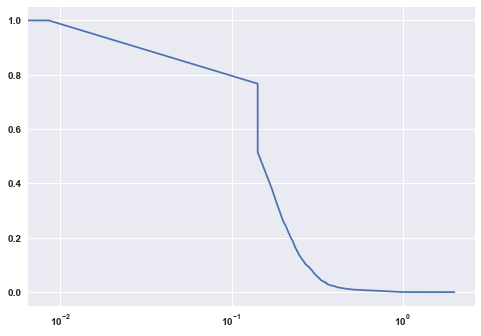

In [4455]:
plt.semilogx(thresh_stim,fpr_stim)

In [4409]:
truth_stim.shape,pred_stim.shape

((44652,), (44652,))

In [3908]:
def compute_auc(fpr,tpr):
    return auc(fpr,tpr)
    

Text(0.5, 1.0, '$C=1e-04$, $r=0.31$ arcsec')

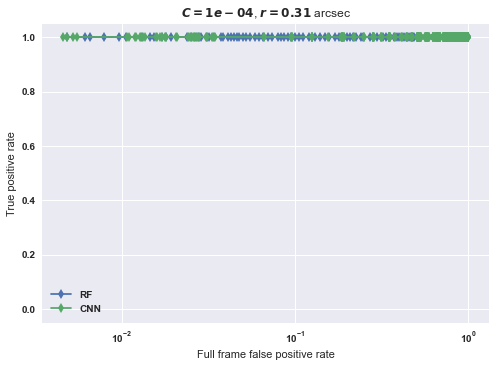

In [4442]:
ax = plt.gca()
plt.plot(fpr_rf,tpr_rf,label='RF',marker='d')
#plt.scatter(fpr_rf,tpr_rf)
plt.plot(fpr_cnn,tpr_cnn,label='CNN',marker='d')
#plt.plot(fpr_sodinn,tpr_sodinn,label='SODINN',marker='d')
#plt.plot(fpr_cnn,fpr_cnn,ls='--',c='k')
#plt.plot(fpf_foronerad[1::]/np.max(fpf_foronerad),tpfs_foronerad[1::]/12,
 #        label='STCM',marker='d')
#plt.plot(total_fps[::]/max(total_fps),total_tpf[::]/12,label='SNR',marker='d')
#plt.plot(fpr_sn,tpr_sn,label='SNR')
#plt.plot(fpr_stim,tpr_stim,label='STIM')
ax.set_xscale('log',nonpositive='mask')
plt.legend()
#plt.xlim(1e-03,1.1)
plt.ylabel("True positive rate")
plt.xlabel("Full frame false positive rate")
plt.title("$C=%1.0e$, $r=%3.2f$ arcsec"%(cont,sep*0.0125))
#plt.savefig("/mnt/diskss/home/rnath/Monday_meetings/Plots_29.08.2022/r_6_C_3e-2.png",dpi=300)

In [4200]:
np.argmin(fpr_cnn)

0

In [4342]:
fp_lowest=[]
tp_lowest=[]
seps=[]
for i in range(6,26):
    #if((i>=9)&(i<=15)):
     #  continue
    #else:
        fpr_cnn,tpr_cnn,thres_cnn = roc_ml(RF,1e-05,i)
        fp_lowest.append(fpr_cnn[2])
        tp_lowest.append(tpr_cnn[2])
        seps.append(i)


/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/mnt/diskss/home/rnath/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


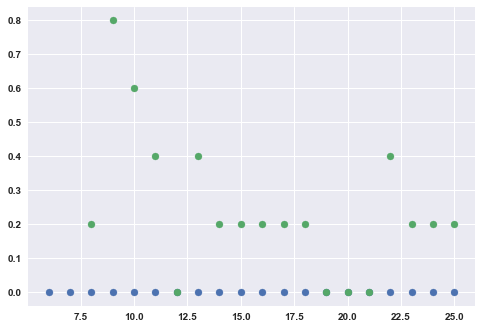

In [4343]:
plt.scatter(seps,fp_lowest)
plt.scatter(seps,tp_lowest)

In [4335]:
np.mean(fp_lowest),np.mean(tp_lowest)

(0.00010211027910142953, 0.0830079365079365)

In [4220]:
fpr_cnn[2],tpr_cnn[2]

(0.0, 0.4)

In [4047]:
len(Cs)*(4)*12

912

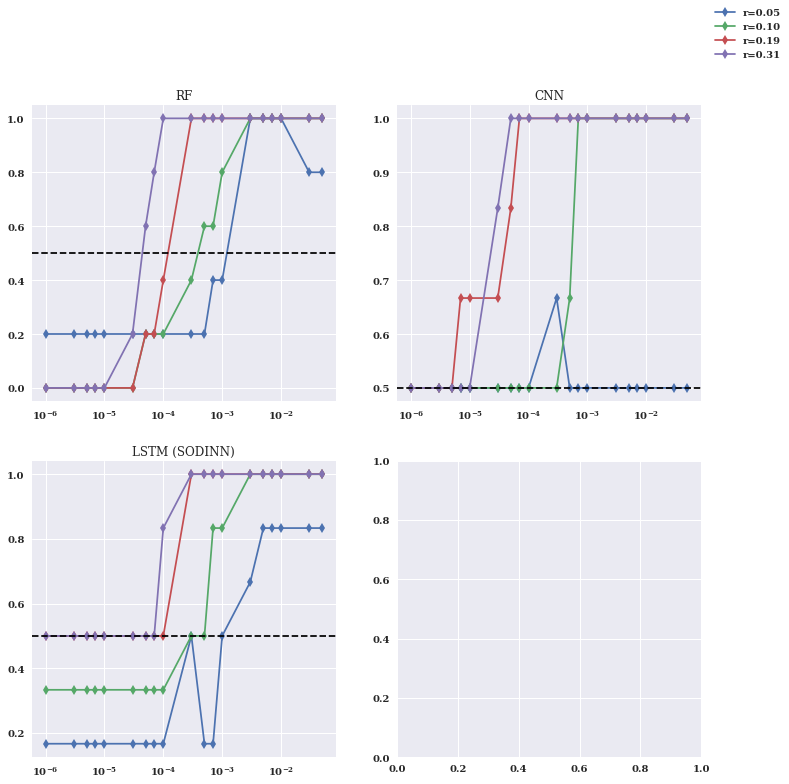

In [1524]:
titles =['RF','CNN','LSTM (SODINN)']
f,axs = plt.subplots(2,2,figsize=(12,12))
for r in rad_distances:
    axs[0,0].semilogx(Cs,tpf_rf[r].values(),marker ='d')
    axs[0,1].semilogx(Cs,tpf_cnn[r].values(),marker ='d')
    axs[1,0].semilogx(Cs,tpf_lstm[r].values(),marker ='d',label="r={0:3.2f}".format(r*0.0125))
for i in range(2):
    for j in range(2):
        if((j==1)& (i==1)):
            break
        axs[j,i].axhline(0.5,ls ='--',c='k')
        axs[i,j].set_title(titles[i+(i+j)])
f.legend()


In [481]:
tpf_rf[25.0][5e-05],tpf_lstm[25.0][1e-04],tpf_cnn[25.0][1e-05]

(0.6666666666666666, 0.6666666666666666, 0.6666666666666666)

In [1503]:
def get_contrast(dictionary,value):
    for key,val in dictionary.items():
        if val ==value:
            return key

In [1512]:
cc_rf = dict()
cc_cnn = dict()
cc_lstm = dict()

for r in rad_distances:
    cc_rf[r] = get_contrast(tpf_rf[r],3.0/5.0)
    cc_cnn[r] = get_contrast(tpf_cnn[r],4.0/6.0)
    cc_lstm[r] = get_contrast(tpf_lstm[r],4.0/6.0)

In [3473]:
trial = open_fits("/mnt/disk12tb/Users/rakesh/SpatialDetection/Data/H1patchesaugmented_HCfov11/augment_H1_aug_2_cont_1e-02_rad_10.0_theta_120.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (83, 3, 11, 11)


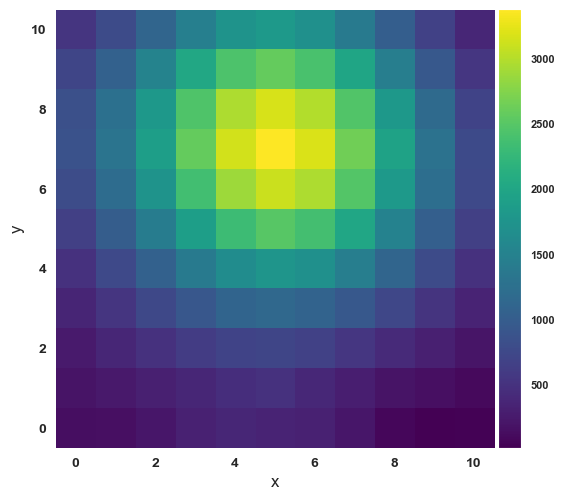

In [3472]:
plot_frames(np.mean(np.median(trial,axis=1),axis=0))

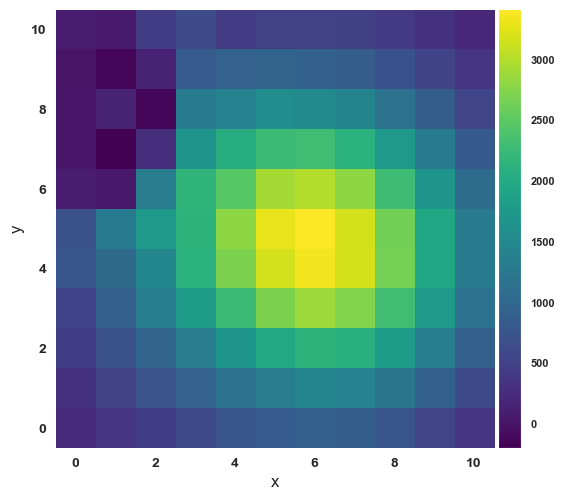

In [3460]:
plot_frames(np.mean(np.median(trial,axis=1),axis=0))

In [1513]:
cc_lstm,cc_rf,cc_cnn

({4.0: 0.003, 8.0: None, 15.0: None, 25.0: None},
 {4.0: None, 8.0: 0.0007, 15.0: None, 25.0: 5e-05},
 {4.0: 0.05, 8.0: 0.0003, 15.0: 5e-05, 25.0: 1e-05})

In [1517]:
tpf_cnn[4.0]

{0.05: 0.6666666666666666,
 0.03: 0.6666666666666666,
 0.01: 0.6666666666666666,
 0.007: 0.5,
 0.005: 0.5,
 0.003: 0.3333333333333333,
 0.001: 0.16666666666666666,
 0.0007: 0.0,
 0.0005: 0.0,
 0.0003: 0.16666666666666666,
 0.0001: 0.0,
 7e-05: 0.0,
 5e-05: 0.0,
 3e-05: 0.0,
 1e-05: 0.0,
 7e-06: 0.0,
 5e-06: 0.0,
 3e-06: 0.0,
 1e-06: 0.0}

In [1441]:
cc_rf

{4.0: None, 8.0: 0.0007, 15.0: None, 25.0: 5e-05}

In [561]:
#cc_cnn[15.0] =3e-05

In [1518]:
cc_rf[15.0] =3e-04
cc_rf[8.0] = 5e-04
cc_cnn[8.0] =5e-04
cc_rf[4.0] = 3e-03
cc_cnn[15.0] = 1e-04
cc_cnn[25.0] = 3e-05
cc_cnn[4.0] = 1e-02

In [1498]:
cont_det_stim=[7e-2,3e-3,5e-4,3e-4]
cont_det_stim_new=[5e-3,7e-4,3e-4,5e-4]
cont_det_snr = [1e-1,3e-3,5e-4,3e-4]

In [1226]:
cc_rf.values()

dict_values([0.05, 0.0005, 0.0003, 5e-05])

In [1396]:
cc_cnn

{4.0: 0.01, 8.0: 0.0003, 15.0: 5e-05, 25.0: 1e-05}

In [1071]:
seps = np.asarray(rad_distances)*0.0125

Text(0, 0.5, 'Detected contrast')

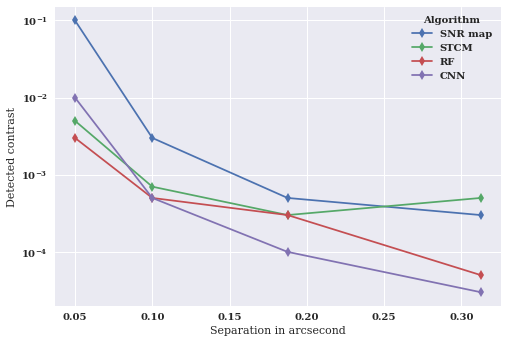

In [1519]:
plt.semilogy(seps,cont_det_snr,marker ='d',label='SNR map')
plt.semilogy(seps,cont_det_stim_new, marker ='d',label ='STCM')
plt.semilogy(seps,cc_rf.values(),marker ='d', label ='RF')
plt.semilogy(seps,cc_cnn.values(),marker ='d', label ='CNN')
plt.legend(title='Algorithm')
plt.xlabel("Separation in arcsecond")
plt.ylabel("Detected contrast")
#plt.semilogy(rad_distances,cc_lstm.values())
#plt.savefig("/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_01.08.2022/cc_final.png")

In [528]:
cc_rf.values()

dict_values([0.03, 0.0005, None, 5e-05])

In [ ]:
plt.plot(cc_rf)

In [520]:
tpf_rf[15.0]

{0.05: 1.0,
 0.03: 1.0,
 0.01: 1.0,
 0.007: 1.0,
 0.005: 1.0,
 0.003: 1.0,
 0.001: 1.0,
 0.0007: 1.0,
 0.0005: 1.0,
 0.0003: 1.0,
 0.0001: 0.5,
 7e-05: 0.5,
 5e-05: 0.3333333333333333,
 3e-05: 0.3333333333333333,
 1e-05: 0.0,
 7e-06: 0.0,
 5e-06: 0.0,
 3e-06: 0.0,
 1e-06: 0.0}

In [509]:
val = 4.0/6.0
tpf_rf[4.0].get(val)

In [514]:
tpf_rf[8.0].get(1.0)

## Reading in full frame

In [250]:
filename = "fitsfiles_vel/cnn_detmap_3e-04_11.0_120.00.fits"
detmap_cnn = open_fits(filename)
filename_sodinn = "fitsfiles_vel/sodinn_detmap_3e-04_11.0_120.00.fits"
detmap_sodinn = open_fits(filename_sodinn)
filename_stim = "fitsfiles/stim_detmap_3e-04_11.0_120.00.fits"
detmap_stim = open_fits(filename_stim)

Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)


In [251]:
rad = float(filename.split('/')[-1].split('_')[3])
theta = float(filename.split('/')[-1].split('_')[4].split('.')[0])

In [254]:
rad,theta

(11.0, 120.0)

In [253]:

y_pos = 30+rad*np.sin(np.deg2rad(theta))
x_pos = 30 +rad*np.cos(np.deg2rad(theta))

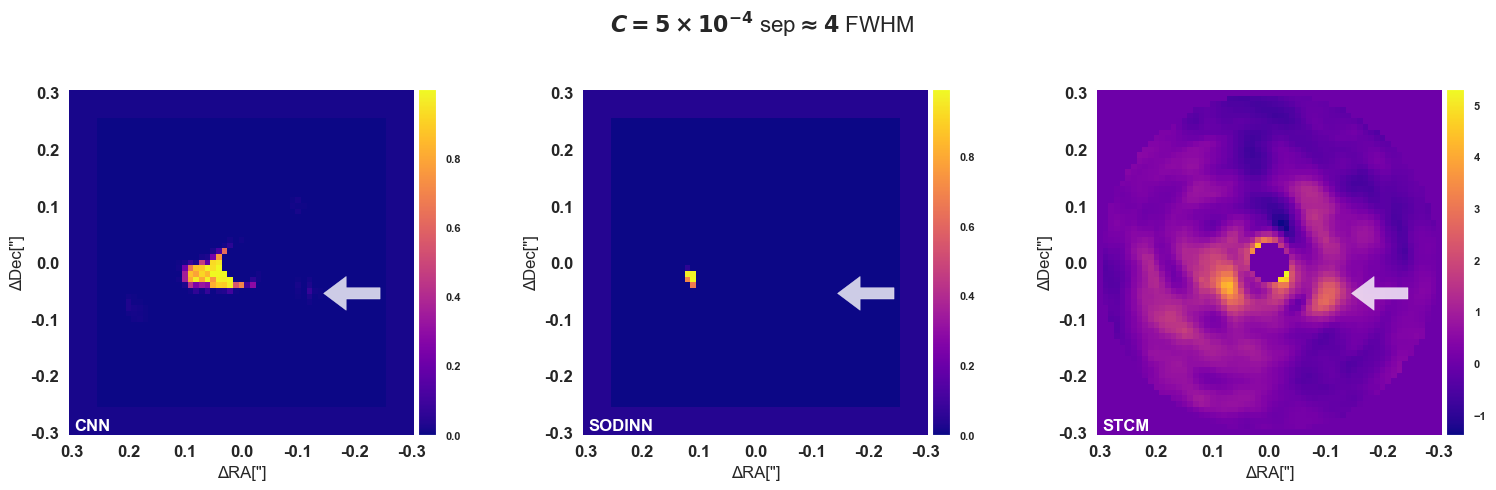

In [255]:
detmap_cnn=mask_circle(detmap_cnn,radius=2.5)
detmap_sodinn = mask_circle(detmap_sodinn,radius=2.5)
detmap_stim = mask_circle(detmap_stim,radius=2.5)
plot_frames((detmap_cnn,detmap_sodinn,detmap_stim),
            cmap='plasma',
           ang_scale=True,
           ang_ticksep=10,
           arrow=(y_pos,x_pos),
           label=('CNN','SODINN','STCM'),
           title ="$C=5\\times 10^{-4}$ sep$\\approx4$ FWHM")#,
           #save="/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_06.11.2022/detmaps_vels_20_1e-04.png",
            #dpi=400)

In [256]:
res_cnn =compute_binary_map(detmap_cnn,
                            thresholds=np.linspace(0.09,0.988,10),fwhm=4.8,injections=(y_pos,x_pos),npix=2,
                            overlap_threshold=0.5,
                            max_blob_fact=3)
res_sodinn = compute_binary_map(detmap_sodinn, 
                                thresholds=np.linspace(0.09,0.95,10),fwhm=4.8,injections=(y_pos,x_pos),npix=2)


res_stim = compute_binary_map(detmap_stim,thresholds=np.linspace(1.3,np.max(detmap_stim)-1e-04,10),
                              fwhm=4.8,injections=(y_pos,x_pos),npix=1,
                             max_blob_fact=4)

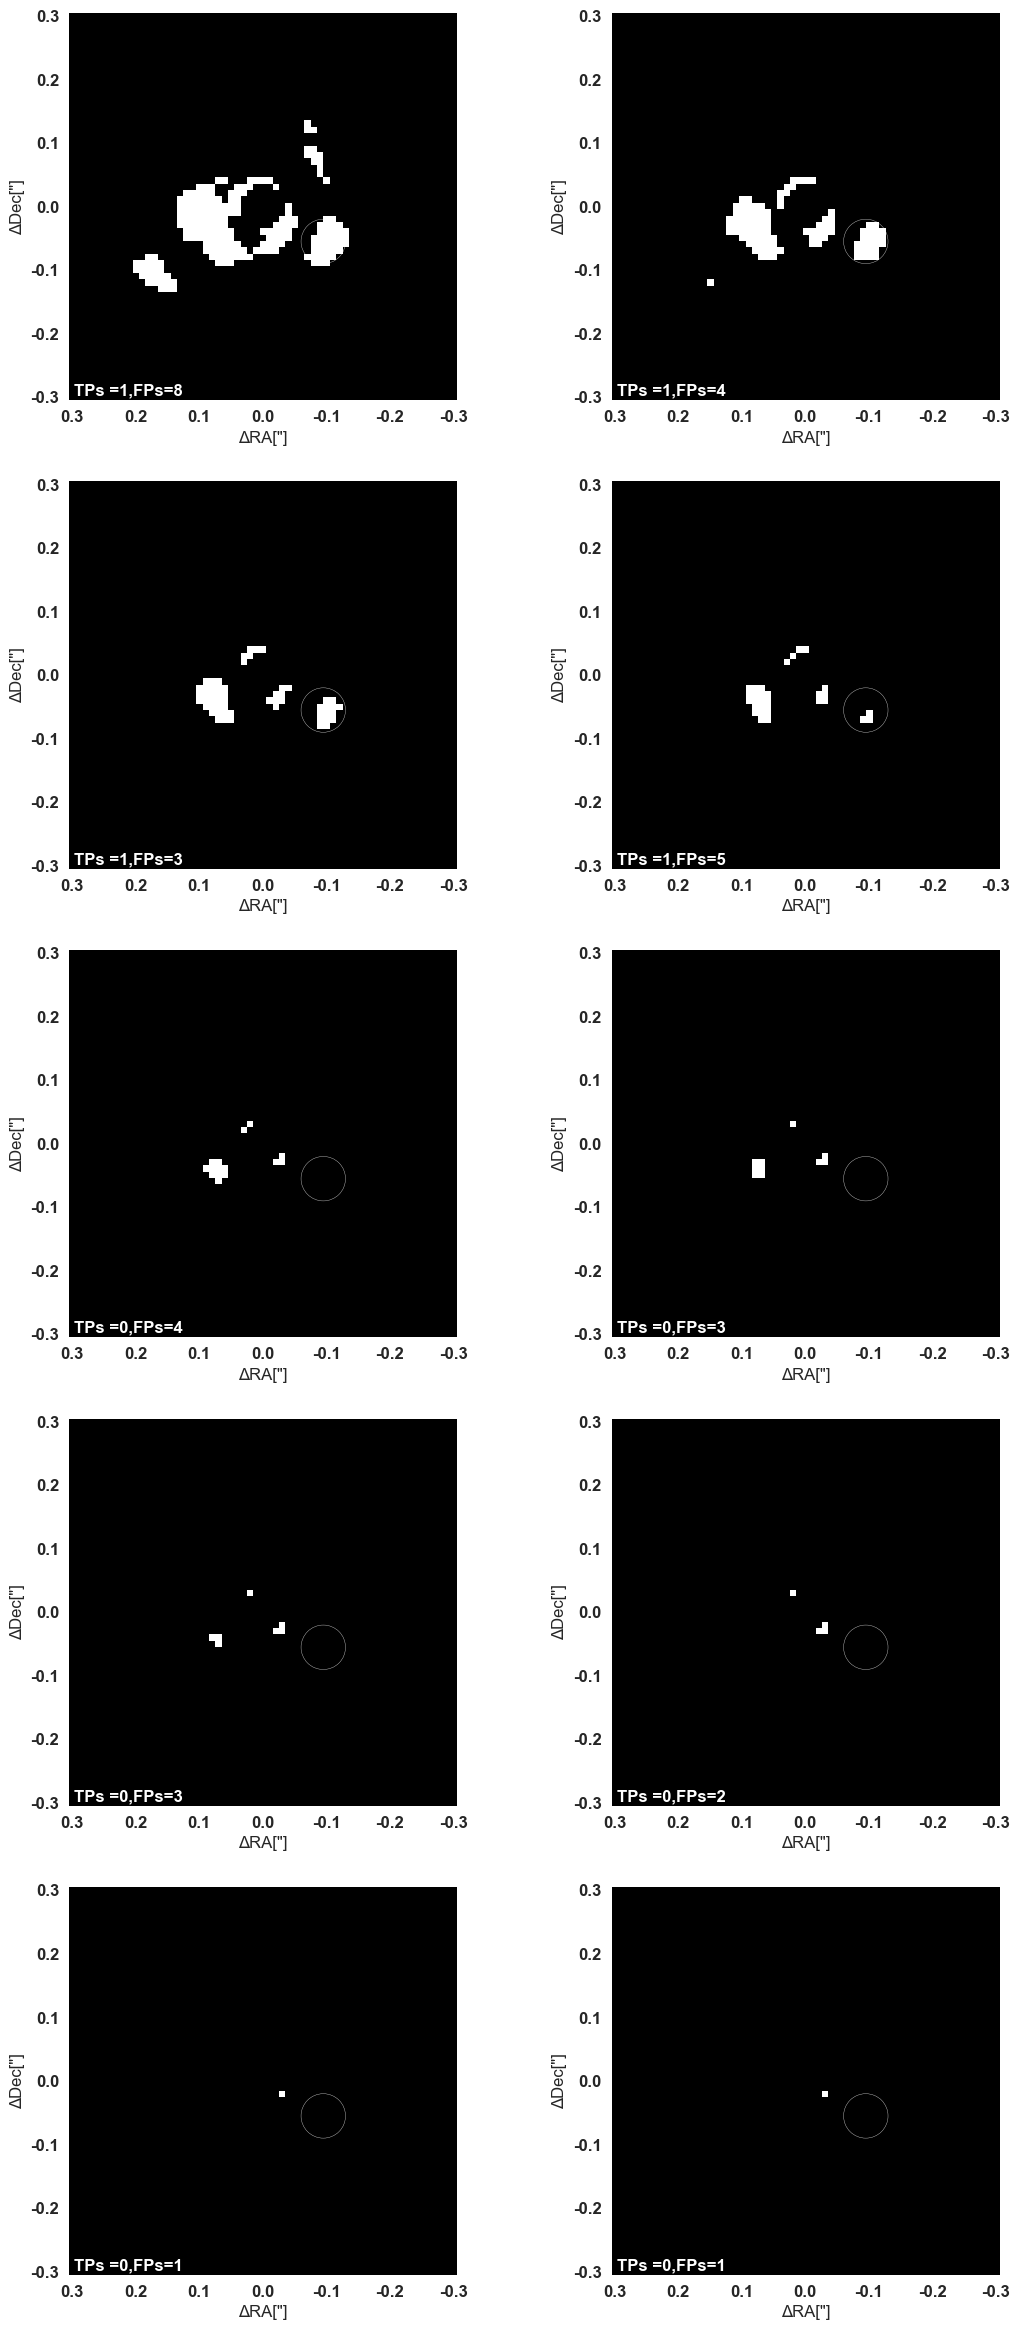

In [257]:
obj = res_stim
labs = tuple(["TPs ={0},FPs={1}".format(o1,o2) for o1,o2 in zip(obj[0],obj[1])])
plot_frames(tuple(obj[2]),rows=5,ang_scale=True,ang_ticksep=10,circle=(y_pos,x_pos),circle_radius=3.5,
            cmap='gray',
           label=labs,
           colorbar=False)

In [244]:
labs

('TPs =1,FPs=7',
 'TPs =1,FPs=4',
 'TPs =1,FPs=3',
 'TPs =1,FPs=5',
 'TPs =2,FPs=4',
 'TPs =0,FPs=3',
 'TPs =0,FPs=3',
 'TPs =0,FPs=1',
 'TPs =0,FPs=1',
 'TPs =0,FPs=1')

In [233]:
res_cnn[0],res_cnn[1]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [200]:
res_stim[0]

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [208]:
(0.999+0.999+0.988)/3

0.9953333333333333

In [250]:
help(compute_binary_map)

Help on function compute_binary_map in module vip_hci.metrics.roc:

compute_binary_map(frame, thresholds, injections, fwhm, npix=1, overlap_threshold=0.7, max_blob_fact=2, plot=False, debug=False)
    Take a list of ``thresholds``, create binary maps and counts detections/fps.
    A blob which is "too big" is split into apertures, and every aperture adds
    one 'false positive'.
    
    Parameters
    ----------
    frame : numpy ndarray
        Detection map.
    thresholds : list or numpy ndarray
        List of thresholds (detection criteria).
    injections : tuple, list of tuples
        Coordinates (x,y) of the injected companions. Also accepts 1d/2d
        ndarrays.
    fwhm : float
        FWHM, used for obtaining the size of the circular aperture centered at
        the injection position (and measuring the overlapping with found blobs).
        The circular aperture has 2 * FWHM in diameter.
    npix : int, optional
        The number of connected pixels, each greater than

# ML +non ML averaging

## STIM +ROC

In [14]:
thresholds = np.linspace(0,10,10)


#tpfs_foronerad=np.zeros(len(thresholds))
#fpf_foronerad=np.zeros(len(thresholds))

In [64]:
angles_chosen=[0.00]
len_sequence = 83
samples_stim = np.zeros(len(angles_chosen)*len_sequence*61*61).reshape(len(angles_chosen),len_sequence,61,61)
noise_stim = np.zeros_like(samples_stim)
arrows =[]
#psf_mask= np.median(masked_psf,axis=0)


for ang in range(len(angles_chosen)):
    #prefix = "/mnt/disk12tb/Users/rakesh/SpatialDetection/Data/CCF_individual_slices_truncatedpsf/"
    prefix = "/mnt/disk12tb/Users/rakesh/SpatialDetection/Data/"
    fits_files=[]
    for i in range(len_sequence):
        fname = prefix+"ccf_cont_5e-04_rad_25.0_theta_{0:3.2f}_frame_{1:02d}.fits".format(angles_chosen[ang],i)
        f = open_fits(fname,
                      verbose=False)
        rad = np.float(fname.split("/")[-1].split('_')[4])
        theta = np.float(fname.split("/")[-1].split('_')[6].split('.')[0])

        #y = 30.0 + rad*np.sin(np.deg2rad(theta))
        #x = 30.0 + rad*np.cos(np.deg2rad(theta))
        y_mod = 30.0 + rad*np.sin(np.deg2rad(theta-rot_angles[i]))
        x_mod = 30.0 + rad*np.cos(np.deg2rad(theta-rot_angles[i]))
       
        #cropped_frame = frame_crop(f[:,:,2],size=11,cenxy=(y_mod,x_mod),verbose=False)
        #crop_mask = mask_circle(cropped_frame,radius=2.2,mode='out')
        #f_mask = mask_circle(f[:,:,2],radius=5.5,mode='in',cx=y_mod,cy=x_mod)
        #f_mask[int(x_mod)-5:int(x_mod)+6,int(y_mod)-5:int(y_mod)+6] =crop_mask
        #f_masked = convolve2d(f[:,:,2],psf_mask,mode='same')
       
       
        fits_files.append(f[:,:,2])
    #print(len(fits_files))
    fits_files = np.asarray(fits_files)
    rad = np.float(fname.split("/")[-1].split('_')[4])
    theta = np.float(fname.split("/")[-1].split('_')[6].split('.')[0])

    y = 30.0 + rad*np.sin(np.deg2rad(theta))
    x = 30.0 + rad*np.cos(np.deg2rad(theta))

    arrows.append([y,x])
    f2 = cube_derotate(fits_files,angle_list=-rot_angles)
    f_noise = cube_derotate(fits_files,angle_list=rot_angles)
    samples_stim[ang,:,:,:] = f2
    noise_stim[ang,:,:,:] = f_noise
    

In [77]:
sigs =[]
threshmaps =[]
mask = create_circular_mask(61,61,center=(30,30),radius= 2.5)
signals=[]
noises =[]
signals_stim=[]
normalized_stims =[]
truth_stims=[]
for i in range(len(angles_chosen)):
    samples_stim[i] = mask_circle(samples_stim[i],radius=3.5,mode='in')
    signal_stim = stim_map(samples_stim[i])
    signal = np.mean(samples_stim[i],axis=0)
    noise = stim_map(noise_stim[i])
    signal[mask] =0
    #noise[mask] =0
    #signal = mask_circle(signal,radius=2.24)
    #signal = mask_circle(signal,radius=2.2,cx=arrows[i][1],cy=arrows[i][0],mode='out')
    noise = mask_circle(noise,radius=3.5)
    print(np.max(signal)/np.nanmax(noise))
    sigs.append((np.max(signal)/np.nanmax(noise)))
    threshmaps.append(signal/np.nanmax(noise))
    signals.append(signal)
    signals_stim.append(signal_stim)
    noises.append(noise)
    normalized_maps=[]
    
    temp = signal_stim
    temp = (temp -temp.min())/(temp.max()-temp.min())
    normalized_stims.append(np.ravel(temp))
    tmap = np.zeros_like(temp)
    tmap = mask_circle(tmap,radius=2.5,fillwith=1,mode='in',cy=arrows[i][1],cx=arrows[i][0])
    truth_stims.append(np.ravel(tmap))




121.42262131259903


In [78]:
binmaps = []
maxs=[]
results_stcm=[]

for i in range(len(signals_stim)):
    #sig = snrmap(signals[i],fwhm=4.8)
    maxs.append(np.max(signals_stim[i]))


for i in range(len(signals_stim)):
    thresholds = np.linspace(1.2,(maxs[i]-0.01),10)
    tpf,fpf,bmp = compute_binary_map(signals_stim[i],thresholds=thresholds,injections=arrows[i]
                                     ,fwhm=4.8,overlap_threshold=0.7,npix=1,max_blob_fact=5)
    results_stcm.append([tpf,fpf,bmp])
    for i in range(len(thresholds)):
        if(tpf[i]>1):
            temp = tpf[i]-1
            fpf[i] =fpf[i]+temp
            tpf[i] =1
            
   # tpfs_foronerad=tpfs_foronerad+tpf
   # fpf_foronerad =fpf_foronerad+fpf
    binmaps.append(bmp)

In [70]:
i

9

In [79]:
fpf,tpf

([7, 4, 5, 5, 3, 3, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [82]:
labs = ["TPs={0},FPs={1},thresh={2}".format(i,j,k) for i,j,k in zip(tpf,fpf,thresholds)]
labs = tuple(labs)

In [85]:
plot_frames(tuple(bmp),
           label=labs,circle=(y,x),circle_radius=2.5,rows=5,circle_color='r',
           save="/mnt/diskss/home/rnath/Monday_meetings/Plots_26.09.2022/stim_binmaps.png")

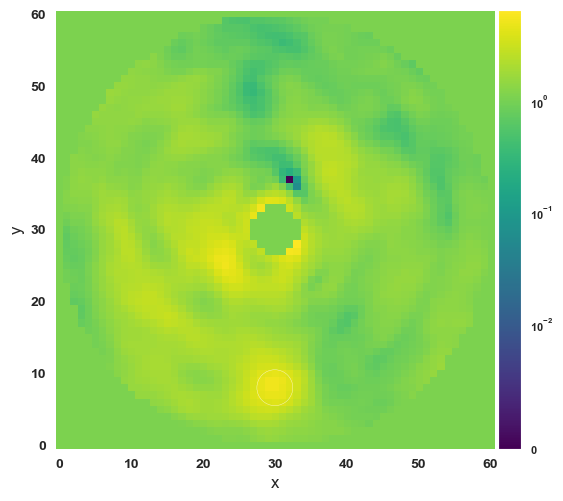

In [78]:
plot_frames(signal_stim,circle =(y,x),circle_radius=2.5,log=True)

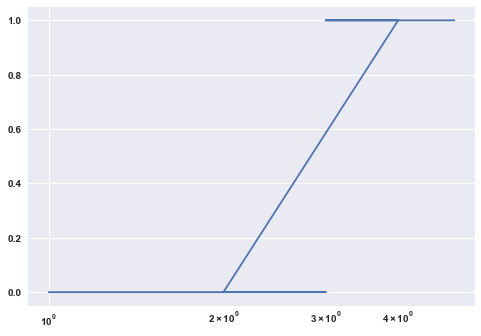

In [45]:
plt.semilogx(fpf,tpf)

## SNR +ROC

In [23]:
#total_fps = np.zeros(len(thresholds))
#total_tpf = np.zeros(len(thresholds))

In [36]:
samples =[]
locs=[]
for ang in angles_chosen:
    filename = "/mnt/disk12tb/Users/rakesh/SpatialDetection/MedianCCF/CCF_median_analysis/ccf_cont_3e-04_rad_{0:3.2f}_theta_{1:3.2f}.fits".format(rad,ang)
    sample = open_fits(filename)
    rad = np.float(filename.split("/")[-1].split('_')[4])
    theta = np.float(filename.split("/")[-1].split('_')[6].split('.')[0])

    y = 30.0 + rad*np.sin(np.deg2rad(theta))
    x = 30.0 + rad*np.cos(np.deg2rad(theta))
    locs.append([y,x])
    samples.append(sample)
    snmaps=[]
for sample in samples:
    snmap =snrmap(sample[:,:,2],fwhm =4.8)
    snmaps.append(snmap)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/disk12tb/Users/rakesh/SpatialDetection/MedianCCF/CCF_median_analysis/ccf_cont_3e-04_rad_23.00_theta_180.00.fits.fits'

In [ ]:
len_thresholds =10

min_maps =[]
binmaps_snr=[]
results=[]
for i in range(len(snmaps)):
    max_val = np.max(snmaps[i]-1e-04)
    res=compute_binary_map(snmaps[i],
                           thresholds=np.linspace(2.0,max_val,len_thresholds),injections=locs[i],
                           fwhm=4.8,max_blob_fact=2,overlap_threshold=0.7,npix=1)
    binmaps_snr.append(res[2])
    tpf =res[0]
    fpf =res[1]
    results.append(res)
    for i in range(len(thresholds)):
        if(tpf[i]>1):
            temp = tpf[i]-1
            fpf[i] =fpf[i]+temp
            tpf[i] =1
            
    total_tpf = total_tpf+np.asarray(tpf)
    total_fps = total_fps+np.asarray(fpf)

## RF +ROC

In [87]:
import joblib
RF_model = joblib.load("/mnt/disk12tb/Users/rakesh/SpatialDetection/Models/rf.joblib")
#tpf_rf = np.zeros(len(thresholds))
#fpf_rf = np.zeros(len(thresholds))

In [98]:
f2.shape

(83, 61, 61)

In [88]:
adi_seq =[]
ang=0
for i in range(83):
    fname = prefix+"ccf_cont_3e-04_rad_{0:3.1f}_theta_{1:3.2f}_frame_{2:02d}.fits".format(rad,theta,i)
    f = open_fits(fname,
                  verbose=False)
    adi_seq.append(f)
adi_seq = np.asarray(adi_seq)
    
seqs=np.zeros(83*61*61*3).reshape(83,3,61,61)#using all three
for i in range(1,4):
    seqs[:,i-1,:,:] = cube_derotate(adi_seq[:,:,:,i],angle_list=-rot_angles)
    

In [172]:
rad,theta

(22.0, 180.0)

In [95]:
#adetmap = np.zeros(61*61).reshape(61,61)
featmap = np.zeros(61*61*121).reshape(61,61,121)
for x in range(5,56):
    for y in range(5,56):
        cropped_adi_seq = cube_crop_frames(seqs,size=11,xy=(y,x),verbose=False)
        test_pixel = np.ravel(np.mean(np.median(cropped_adi_seq,axis=1),axis=0))
        test_pixel = (test_pixel-test_pixel.min())/(test_pixel.max()-test_pixel.min())
        featmap[x,y] = test_pixel
#detmap[x,y] = RF.predict_proba(test_pixel)[:

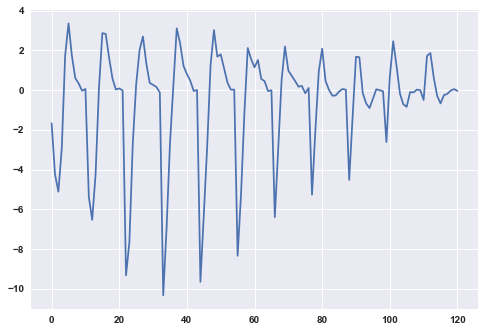

In [90]:
plt.plot(test_pixel)

In [97]:
predmap=RF_model.predict_proba(featmap.reshape(61*61,121))[:,1]

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    0.1s finished


In [92]:
det_map = frame_crop(predmap.reshape(61,61),51)

New shape: (51, 51)


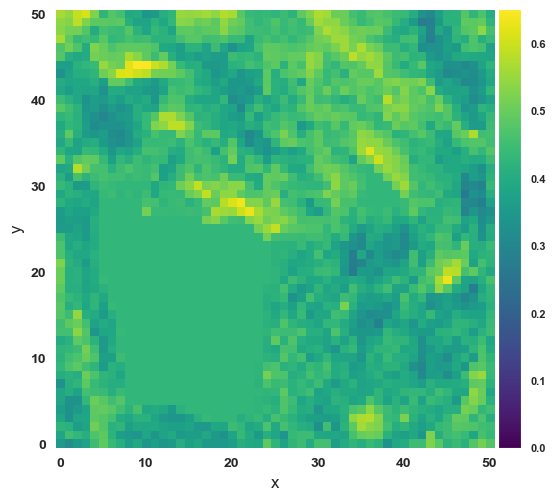

In [98]:
plot_frames(det_map,vmin=0)

In [ ]:
#largemask values
#FPF stim[369. 331. 221.  83.  76.  50.  75.  50.  50.  25.] 
#FPF cnn[215. 158. 153. 152. 150. 150. 101.  75.  26.  25.] 
#FPF sodinn[150.  75.  75.  75.  75.  75.  75.  75.  76.  38.]
#[67. 66. 64. 59. 56. 53. 50. 50. 50. 50.] [56. 55. 53. 52. 50. 50. 50. 50. 50. 50.] [51. 51. 53. 50. 50. 50. 50. 50. 50. 47.]

In [ ]:
#smallmask
#[441. 357. 177.  75.  75.  69.  54.  50.  50.  47.] [282. 158. 150. 152. 150. 150.  75.  75.  75.  75.] [225. 225. 225. 224. 148. 142.  75.  75.  76.  75.] [145.  77.  75.  75. 156. 150. 150. 150. 225.  75.]
#[67. 56. 50. 50. 50. 50. 48. 45. 38. 30.] [55. 54. 52. 50. 50. 50. 50. 50. 50. 42.] [51. 52. 50. 49. 48. 46. 46. 46. 46. 37.] [50. 50. 50. 50. 50. 45. 41. 34. 25.  0.]

In [11]:
#smallest mask
fpf_stim=[516., 414., 297., 371., 342., 217., 195.,  72.,  58.,  52.,] 
fpf_cnn=[282., 158., 150., 152., 150., 150.,  75.,  75.,  75.,  75.,] 
fpf_sodinn=[225., 225., 225., 224., 148., 142.,  75.,  75.,  76.,  75.,] 
fpf_rf =[145.,  77.,  75.,  75., 156., 150., 150., 150., 225.,  75.,]
tpf_stim=[67., 51., 50., 50., 49., 45., 34., 26., 25., 23.,]
tpf_cnn=[55., 54., 52., 50., 50., 50., 50., 50., 50., 42.,] 
tpf_sodinn=[51., 52., 50., 49., 48., 46., 46., 46., 46., 37.,] 
tpf_rf=[50., 50., 50., 50., 50., 45., 41., 34., 25.,  0.,]


In [247]:
#large mask small range
fpf_stim_large=[374., 193., 155.,  28.,  25.,  25.,  50.,  25.,  25.,  25.,] 
fpf_cnn_large =[105.,  30.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,] 
fpf_sodinn_large =[75., 33., 32., 31., 31., 31., 31., 31., 32., 31.,] 
fpf_rf_large =[75., 25., 25., 25., 25., 25., 25., 25., 25., 25.,]
tpf_stim_large=[67., 64., 62., 57., 56., 54., 51., 50., 50., 50.,] 
tpf_cnn_large =[51., 50., 50., 50., 50., 50., 50., 50., 50., 50.,] 
tpf_sodinn_large=[51., 53., 54., 51., 50., 50., 50., 49., 48., 46.,] 
tpf_rf_large=[50., 50., 50., 50., 50., 50., 50., 50., 50., 53.,]

In [104]:
#fpf_stim = [369., 331., 221.,  83.,  76.,  50.,  75.,  50.,  50.,  25.,]
#tpf_stim = [67., 66., 64., 59., 56., 53., 50., 50., 50., 50.,]
#fpf_cnn = [215., 158., 153., 152., 150., 150., 101.,  75.,  26.,  25.]
#tpf_cnn = [56., 55., 53., 52., 50., 50., 50., 50., 50., 50.,]

In [194]:
#large mask #large range
fpf_stim =[921., 620., 338., 235., 161., 100., 102.,  25.,  50.,  25.,] 
fpf_cnn=[135., 127.,  75.,  75.,  25.,  25.,  25.,  25.,  25.,  25.,] 
fpf_sodinn=[75., 34., 32., 32., 31., 31., 31., 31., 32., 31.,] 
fpf_rf=[275., 153.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,]
tpf_stim=[49., 67., 66., 73., 73., 70., 63., 56., 50., 50.,] 
tpf_cnn=[56., 54., 51., 51., 50., 50., 50., 50., 50., 50.,] 
tpf_sodinn=[54., 54., 53., 51., 50., 50., 49., 50., 48., 46.,] 
tpf_rf=[58., 54., 52., 52., 50., 50., 50., 50., 50., 53.,]

In [ ]:
#smallmask -large range
#[872. 412. 350. 310. 291. 206. 133.  79.  36.  27.] [73. 75. 75. 75. 75. 75. 75. 75. 75. 75.] [ 75.  75.  75.  75.  75.  75.  75.  75.  76. 225.] [154.  77.  75.  75. 150.  75.  75.  75.  75. 153.]
#[45. 75. 75. 75. 75. 73. 65. 53. 50. 48.] [75. 75. 75. 75. 75. 75. 75. 75. 74. 42.] [76. 77. 75. 74. 73. 71. 71. 71. 71. 62.] [73. 75. 75. 75. 75. 70. 66. 59. 50. 22.]

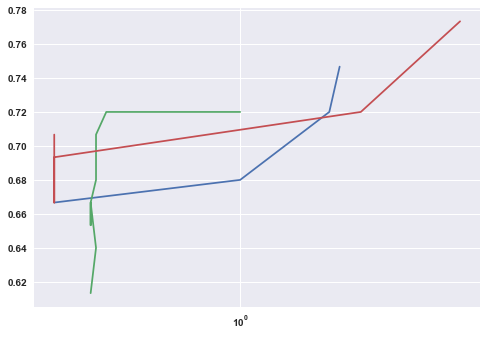

In [156]:
plt.gca()
#plt.plot((np.asarray(fpf_stim)/75.),np.asarray(tpf_stim)/75.)
plt.plot((np.asarray(fpf_cnn)/75.),np.asarray(tpf_cnn)/75.)

plt.plot((np.asarray(fpf_sodinn)/75),np.asarray(tpf_sodinn)/75.)
plt.plot((np.asarray(fpf_rf)/75.),np.asarray(tpf_rf)/75.)

#plt.plot(np.log10(np.asarray(fpf_stim_large)/75.),np.asarray(tpf_stim_large)/75.,ls='--',marker='d')
#plt.plot(np.log10(np.asarray(fpf_cnn_large)/75.),np.asarray(tpf_cnn_large)/75.,ls='--',marker='d')

#plt.plot(np.log10(np.asarray(fpf_sodinn_large)/75),np.asarray(tpf_sodinn_large)/75.,ls='--',marker='d')

#plt.plot(np.log10(np.asarray(fpf_rf_large)/75.),np.asarray(tpf_rf_large)/75.,ls='--',marker='d')

plt.xscale('log')
#plt.xlim(1e-01,4)
#plt.xscale('log')

In [176]:
y_pos = frame_center(det_map)[0]+rad*np.sin(np.deg2rad(theta))
x_pos = frame_center(det_map)[1]+rad*np.cos(np.deg2rad(theta))

In [198]:
thresh=np.linspace(0.12,1.0-1e-07,10)
res =compute_binary_map(det_map,thresholds=thresh,injections=(y_pos,x_pos),
                           fwhm=4.8,max_blob_fact=5,overlap_threshold=0.7,npix=1)

In [179]:
tpf =res[0]
fpf =res[1]

for i in range(len(thresh)):
    if(tpf[i]>1):
        temp = tpf[i]-1
        fpf[i] =fpf[i]+temp
        tpf[i] =1

tpf_rf = tpf_rf+np.asarray(tpf)
fpf_rf = fpf_rf+np.asarray(fpf)

In [194]:
tpf_rf,fpf_rf,tpfs_foronerad,fpf_foronerad

(array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
 array([124., 145., 171., 171., 156., 137., 136.,  84.,  69.,  27.]),
 array([6., 5., 5., 5., 5., 4., 2., 2., 2., 0.]),
 array([30., 24., 30., 18., 24., 12., 18., 18., 18.,  6.]))

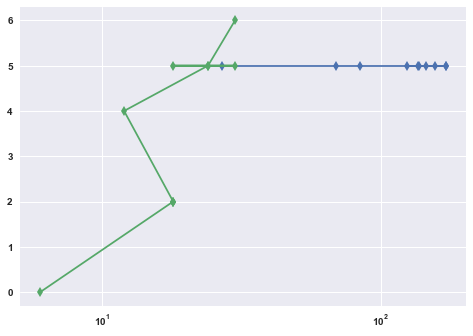

In [193]:
ax=plt.gca()
plt.plot(fpf_rf,tpf_rf,marker='d')
plt.plot(fpf_foronerad,tpfs_foronerad,marker='d')
ax.set_xscale('log')

In [159]:
fpf_stim =[441., 356., 178.,  75.,  75.,  69.,  54.,  50.,  50.,  46.,] 
fpf_cnn=[149.,  75.,  75.,  75.,  75.,  75.,  75.,  75.,  75.,  75.,] 
fpf_sodinn=[225., 225., 225., 224., 148., 142.,  75.,  75.,  76.,  75.,] 
fpf_rf=[145.,  77.,  76., 150., 150., 150.,  75.,  75., 150.,  75.,]
tpf_stim =[67., 56., 50., 50., 50., 50., 48., 45., 38., 29.,] 
tpf_cnn=[51., 50., 50., 50., 50., 50., 50., 50., 49., 39.,] 
tpf_sodinn=[44., 44., 44., 43., 42., 42., 42., 42., 42., 35.,] 
tpf_rf=[50., 50., 50., 50., 50., 45., 41., 34., 25.,  0.,]


Text(0.5, 1.0, '4-5 FWHMs with a contrast range $10^{-4}$ to $5\\times10^{-4}$')

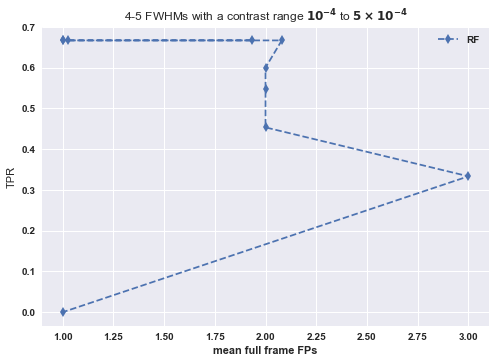

In [289]:
ax=plt.gca()
#plt.plot(np.asarray(fpf_stim)/75.0,np.asarray(tpf_stim)/75.,ls='--',marker='d',label='STCM')
#plt.plot(np.asarray(fpf_cnn)/75.0,np.asarray(tpf_cnn)/75.,ls='--',marker='d',label='CNN')
#plt.plot(np.asarray(fpf_sodinn)/75.0,np.asarray(tpf_sodinn)/75.,ls='--',marker='d',label='SODINN')
plt.plot(np.asarray(fpf_rf)[::]/75.,np.asarray(tpf_rf)[::]/75.,ls='--',marker='d',label="RF")
#ax.set_xscale('log')
plt.legend()
plt.xlabel('mean full frame FPs',fontweight='bold')
plt.ylabel('TPR')
plt.title('4-5 FWHMs with a contrast range $10^{-4}$ to $5\\times10^{-4}$')
#plt.savefig("/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_08.09.2022/smallmask_4_5fwhm_withrf.png")

In [192]:
16/4.8,20/4.8

(3.3333333333333335, 4.166666666666667)

Text(0, 0.5, 'TPR')

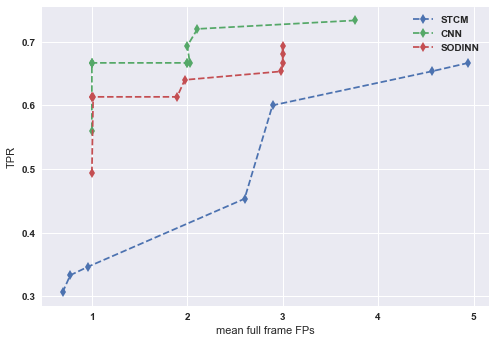

In [163]:
ax=plt.gca()
plt.plot(np.asarray(fpf_stim[3::])/75.0,np.asarray(tpf_stim[3::])/75.,ls='--',marker='d',label='STCM')
plt.plot(np.asarray(fpf_cnn)/75.0,np.asarray(tpf_cnn)/75.,ls='--',marker='d',label='CNN')
plt.plot(np.asarray(fpf_sodinn)/75.0,np.asarray(tpf_sodinn)/75.,ls='--',marker='d',label='SODINN')
#plt.plot(np.asarray(fpf_rf)[::]/75.,np.asarray(tpf_rf)[::]/75.,ls='--',marker='d',label='RF')
#ax.set_xscale('log')
plt.legend()
plt.xlabel('mean full frame FPs')
plt.ylabel('TPR')
#plt.xlim(0,4)

In [258]:
#closer in 3-4 FWHM#mask5.5
tpf_stim=[57., 49., 43., 40., 40., 40., 40., 36., 33., 26.,] 
tpf_cnn=[43., 40., 40., 40., 40., 40., 40., 40., 40., 16.,] 
tpf_sodinn=[36., 36., 36., 36., 36., 36., 36., 36., 36., 33.,] 
tpf_rf=[37., 40., 40., 40., 40., 39., 36., 35., 24.,  0.,]

In [171]:
#closer in 3-4 FWHM mask2.5
tpf_stim =[57., 43.,40., 40., 35., 24., 20., 18., 13.,  4.] 
tpf_cnn=[43., 40., 40., 40., 40., 40., 40., 40., 40., 16.] 
tpf_sodinn=[36., 36., 36., 36., 36., 36., 36., 36., 36., 33.] 
tpf_rf=[36., 40., 40., 40., 40., 39., 36., 35., 24., 0.,]

Text(0.5, 1.0, '3-4 FWHMs with a contrast range $10^{-4}$ to $5\\times10^{-4}$')

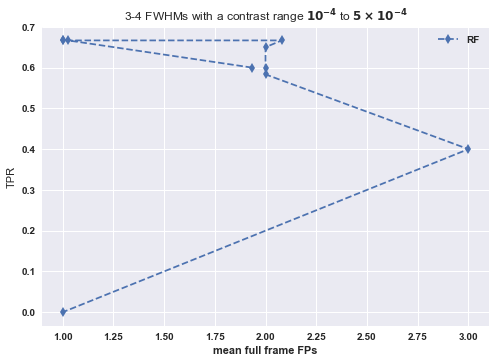

In [287]:
ax=plt.gca()
#plt.plot(np.asarray(fpf_stim)/75.0,np.asarray(tpf_stim)/60.,ls='--',marker='d',label='STCM')
#plt.plot(np.asarray(fpf_cnn)/75.0,np.asarray(tpf_cnn)/60.,ls='--',marker='d',label='CNN')
#plt.plot(np.asarray(fpf_sodinn)/75.0,np.asarray(tpf_sodinn)/60.,ls='--',marker='d',label='SODINN')
plt.plot(np.asarray(fpf_rf)[::]/75.,np.asarray(tpf_rf)[::]/60.,ls='--',marker='d',label='RF')
#ax.set_xscale('log')
plt.legend()
plt.xlabel('mean full frame FPs',fontweight='bold')
plt.ylabel('TPR')
plt.title('3-4 FWHMs with a contrast range $10^{-4}$ to $5\\times10^{-4}$')
#plt.savefig("/mnt/diskss/home/rnath/Monday_meetings/PaperPlots_08.09.2022/smallmask_3_4fwhm_withrf.png")

## Read fits

In [7]:
tpr_stim = open_fits("stats_roc_runs/tpr_stim_mask_0.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
tpr_sodinn = open_fits("stats_roc_runs/tpr_sodinn_mask_0.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
tpr_rf = open_fits("stats_roc_runs/tpr_rf_mask_0.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
tpr_cnn = open_fits("stats_roc_runs/tpr_cnn_mask_0.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [5]:
fpr_stim = open_fits("stats_roc_runs/fpr_stim_mask_0.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_sodinn = open_fits("stats_roc_runs/fpr_sodinn_mask_0.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_rf = open_fits("stats_roc_runs/fpr_rf_mask_0.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_cnn = open_fits("stats_roc_runs/fpr_cnn_mask_0.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [9]:
thresh_stim = open_fits("stats_roc_runs/thresh_stim_mask_0.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
thresh_cnn = open_fits("stats_roc_runs/thresh_cnn_mask_0.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [3]:
mask = 3.5
tpr_stim_2 = open_fits("stats_roc_runs/tpr_stim_mask_{0:1.1f}_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits".format(mask))
tpr_sodinn_2 = open_fits("stats_roc_runs/tpr_sodinn_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
tpr_rf_2 = open_fits("stats_roc_runs/tpr_rf_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
tpr_cnn_2 = open_fits("stats_roc_runs/tpr_cnn_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_stim_2 = open_fits("stats_roc_runs/fpr_stim_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_sodinn_2 = open_fits("stats_roc_runs/fpr_sodinn_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_rf_2 = open_fits("stats_roc_runs/fpr_rf_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_cnn_2 = open_fits("stats_roc_runs/fpr_cnn_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
thresh_stim_2 = open_fits("stats_roc_runs/thresh_stim_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
thresh_cnn_2 = open_fits("stats_roc_runs/thresh_cnn_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


No handles with labels found to put in legend.


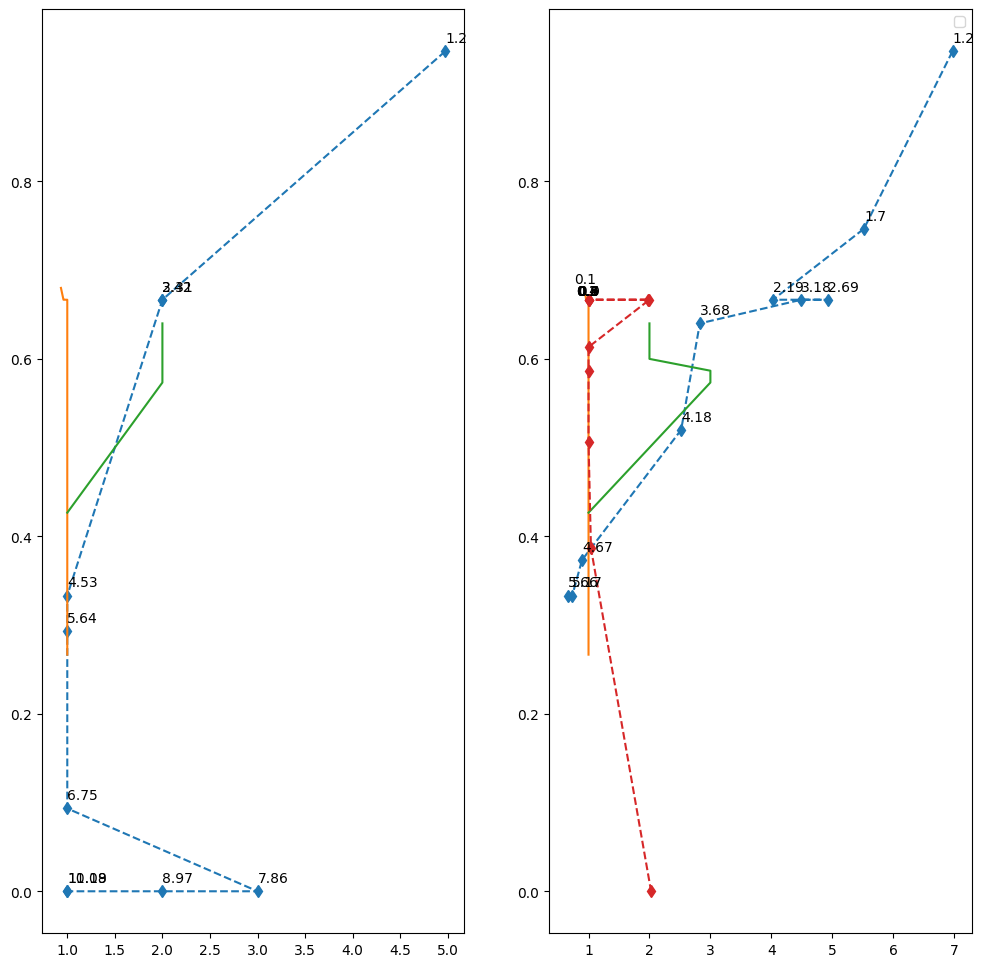

In [13]:
f,ax=plt.subplots(1,2,figsize=(12,12))
ax[0].plot(fpr_stim,tpr_stim/1.0,ls='--',marker='d')
for i in range(10):
    ax[0].text(fpr_stim[i],tpr_stim[i]+0.01,str(np.round(thresh_stim[i],2)))
ax[0].plot(fpr_cnn/1.0,tpr_cnn/1.0)
ax[0].plot(fpr_sodinn[:]/1.0,tpr_sodinn[:]/1.0)
#ax[0].plot(fpr_rf[0::],tpr_rf[0::],marker='d',ls='--')
#for i in range(9):
 #   ax[0].text(fpr_rf[i]+0.01,tpr_rf[i]+0.01,str(np.round(thresh_rf[i],2)),va='center',ha='center')
ax[1].plot(fpr_stim_2,tpr_stim_2/1.0,ls='--',marker='d')
for i in range(10):
    ax[1].text(fpr_stim_2[i],tpr_stim_2[i]+0.01,str(np.round(thresh_stim_2[i],2)))
ax[1].plot(fpr_cnn_2/1.0,tpr_cnn_2/1.0)
ax[1].plot(fpr_sodinn_2/1.0,tpr_sodinn_2/1.0)
ax[1].plot(fpr_rf_2[0::],tpr_rf_2[0::],marker='d',ls='--')
for i in range(9):
    ax[1].text(fpr_cnn_2[i]+0.01,tpr_cnn_2[i]+0.01,str(np.round(thresh_cnn_2[i],2)),va='center',ha='center')
plt.legend()
#plt.xlim(0.9,1.5)
#plt.xlim(0.3,1.0)
#ax.set_xscale('log')
#ax.set_yscale('log')

Help on AxesSubplot in module matplotlib.axes._subplots object:

class AxesSubplot(SubplotBase, matplotlib.axes._axes.Axes)
 |  AxesSubplot(fig, *args, **kwargs)
 |  
 |  Base class for subplots, which are :class:`Axes` instances with
 |  additional methods to facilitate generating and manipulating a set
 |  of :class:`Axes` within a figure.
 |  
 |  Method resolution order:
 |      AxesSubplot
 |      SubplotBase
 |      matplotlib.axes._axes.Axes
 |      matplotlib.axes._base._AxesBase
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods inherited from SubplotBase:
 |  
 |  __init__(self, fig, *args, **kwargs)
 |      Parameters
 |      ----------
 |      fig : `matplotlib.figure.Figure`
 |      
 |      *args : tuple (*nrows*, *ncols*, *index*) or int
 |          The array of subplots in the figure has dimensions ``(nrows,
 |          ncols)``, and *index* is the index of the subplot being created.
 |          *index* starts at 1 in the upper left corner and inc

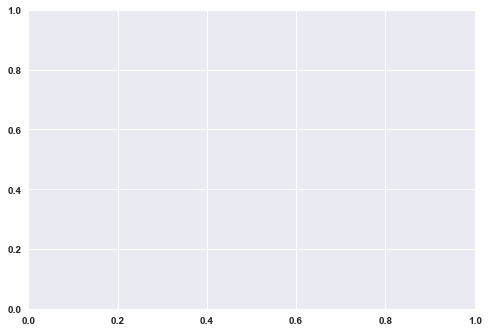

In [720]:
help(plt.gca())

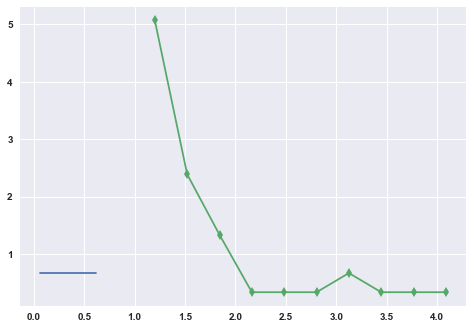

In [713]:
ax=plt.gca()
plt.plot(thresh_rf,tpr_sodinn)
#plt.plot(thresh_stim,fpr_stim,marker='d')
plt.plot(thresh_stim,fpr_stim,marker='d')
#ax.set_xscale('log')

In [707]:
tpr_sodinn,fpr_sodinn,fpr_stim,tpr_stim

(array([0.6666667, 0.6666667, 0.6666667, 0.6666667, 0.6666667, 0.6666667,
        0.6666667, 0.6666667, 0.6666667, 0.6666667], dtype=float32),
 array([0.33333334, 0.33333334, 0.33333334, 0.33333334, 0.33333334,
        0.33333334, 0.33333334, 0.33333334, 0.33333334, 0.33333334],
       dtype=float32),
 array([5.0666666 , 2.3866668 , 1.3333334 , 0.33333334, 0.33333334,
        0.33333334, 0.6666667 , 0.33333334, 0.33333334, 0.33333334],
       dtype=float32),
 array([0.94666666, 0.92      , 0.8933333 , 0.82666665, 0.81333333,
        0.7866667 , 0.73333335, 0.72      , 0.6933333 , 0.6666667 ],
       dtype=float32))

## with vel

In [269]:
mask = 3.5
tpr_stim_vel_0 = open_fits("stats_roc_runs_vel/tpr_stim_mask_3.5_cont_from1e-04_to_5e-04_rad_from_9.00_to_13.00.fits")
tpr_sodinn_vel_0 = open_fits("stats_roc_runs_vel/tpr_sodinn_mask_3.5_cont_from1e-04_to_5e-04_rad_from_9.00_to_13.00.fits")
tpr_cnn_vel_0 = open_fits("stats_roc_runs_vel/tpr_cnn_mask_3.5_cont_from1e-04_to_5e-04_rad_from_9.00_to_13.00.fits")
fpr_stim_0 = open_fits("stats_roc_runs_vel/fpr_stim_mask_3.5_cont_from1e-04_to_5e-04_rad_from_9.00_to_13.00.fits")
fpr_sodinn_vel_0 = open_fits("stats_roc_runs_vel/fpr_sodinn_mask_3.5_cont_from1e-04_to_5e-04_rad_from_9.00_to_13.00.fits")
#fpr_rf_2 = open_fits("stats_roc_runs/fpr_rf_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_cnn_vel_0 = open_fits("stats_roc_runs_vel/fpr_cnn_mask_3.5_cont_from1e-04_to_5e-04_rad_from_9.00_to_13.00.fits")
thresh_stim_vel_0 = open_fits("stats_roc_runs_vel/thresh_stim_mask_3.5_cont_from1e-04_to_5e-04_rad_from_9.00_to_13.00.fits")
thresh_cnn_vel_0 = open_fits("stats_roc_runs_vel/thresh_cnn_mask_3.5_cont_from1e-04_to_5e-04_rad_from_9.00_to_13.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [279]:
mask = 3.5
start_pix =19.0
end_pix =23.0
tpr_stim_vel = open_fits("stats_roc_runs_vel/tpr_stim_mask_3.5_cont_from3e-04_to_5e-04_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix))
tpr_sodinn_vel = open_fits("stats_roc_runs_vel/tpr_sodinn_mask_3.5_cont_from3e-04_to_5e-04_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix))
tpr_cnn_vel = open_fits("stats_roc_runs_vel/tpr_cnn_mask_3.5_cont_from3e-04_to_5e-04_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix))
fpr_stim = open_fits("stats_roc_runs_vel/fpr_stim_mask_3.5_cont_from3e-04_to_5e-04_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix))
fpr_sodinn_vel = open_fits("stats_roc_runs_vel/fpr_sodinn_mask_3.5_cont_from3e-04_to_5e-04_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix))
#fpr_rf_2 = open_fits("stats_roc_runs/fpr_rf_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_cnn_vel = open_fits("stats_roc_runs_vel/fpr_cnn_mask_3.5_cont_from3e-04_to_5e-04_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix))
thresh_stim_vel = open_fits("stats_roc_runs_vel/thresh_stim_mask_3.5_cont_from3e-04_to_5e-04_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix))
thresh_cnn_vel = open_fits("stats_roc_runs_vel/thresh_cnn_mask_3.5_cont_from3e-04_to_5e-04_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix))

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


Text(0, 0.5, 'TPR')

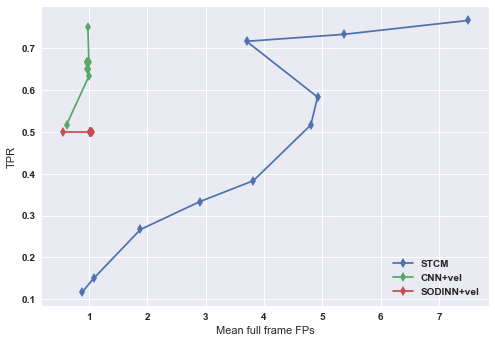

In [280]:

plt.plot(fpr_stim_0,tpr_stim_vel_0,label='STCM',marker='d')
plt.plot(fpr_cnn_vel_0,tpr_cnn_vel_0,label='CNN+vel',marker ='d')
#plt.plot(fpr_stim_2,tpr_stim_2)

plt.plot(fpr_sodinn_vel_0,tpr_sodinn_vel_0,label='SODINN+vel',marker='d')
#plt.plot(np.asarray(fpf_cnn)/75.0,np.asarray(tpf_cnn)/75.,ls='--',marker='d',label='CNN')
#plt.plot(np.asarray(fpf_sodinn)/75.0,np.asarray(tpf_sodinn)/75.,ls='--',marker='d',label='SODINN')
plt.legend()
plt.xlabel("Mean full frame FPs")
plt.ylabel("TPR")
#plt.savefig("/mnt/diskss/home/rnath/Monday_meetings/FRIAplot/withvel.png",dpi =300)

Text(0, 0.5, 'TPR')

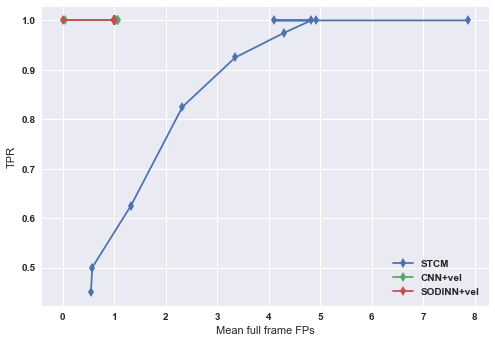

In [281]:

plt.plot(fpr_stim,tpr_stim_vel,label='STCM',marker='d')
plt.plot(fpr_cnn_vel,tpr_cnn_vel,label='CNN+vel',marker ='d')
#plt.plot(fpr_stim_2,tpr_stim_2)

plt.plot(fpr_sodinn_vel,tpr_sodinn_vel,label='SODINN+vel',marker='d')
#plt.plot(np.asarray(fpf_cnn)/75.0,np.asarray(tpf_cnn)/75.,ls='--',marker='d',label='CNN')
#plt.plot(np.asarray(fpf_sodinn)/75.0,np.asarray(tpf_sodinn)/75.,ls='--',marker='d',label='SODINN')
plt.legend()
plt.xlabel("Mean full frame FPs")
plt.ylabel("TPR")

#plt.plot(fpr_stim_0,tpr_stim_vel_0,label='STCM',marker='d')
#plt.plot(fpr_cnn_vel_0,tpr_cnn_vel_0,label='CNN+vel',marker ='d')
#plt.plot(fpr_stim_2,tpr_stim_2)

#plt.plot(fpr_sodinn_vel_0,tpr_sodinn_vel_0,label='SODINN+vel',marker='d')
#plt.plot(np.asarray(fpf_cnn)/75.0,np.asarray(tpf_cnn)/75.,ls='--',marker='d',label='CNN')
#plt.plot(np.asarray(fpf_sodinn)/75.0,np.asarray(tpf_sodinn)/75.,ls='--',marker='d',label='SODINN')
plt.legend()
plt.xlabel("Mean full frame FPs")
plt.ylabel("TPR")
#plt.savefig("/mnt/diskss/home/rnath/Monday_meetings/FRIAplot/wit
#plt.savefig("/mnt/diskss/home/rnath/Monday_meetings/FRIAplot/withvel.png",dpi =300)

In [37]:
tpr_cnn_vel,tpr_stim_vel,tpr_sodinn_vel

(array([0.8472222, 0.8333333, 0.8472222, 0.8611111, 0.8472222, 0.8333333,
        0.8194444, 0.7916667, 0.7638889, 0.6666667], dtype=float32),
 array([0.875     , 0.7361111 , 0.6666667 , 0.6666667 , 0.6527778 ,
        0.625     , 0.5277778 , 0.4027778 , 0.33333334, 0.30555555],
       dtype=float32),
 array([0.6388889, 0.6388889, 0.6388889, 0.6388889, 0.6388889, 0.6527778,
        0.6527778, 0.6527778, 0.6527778, 0.6527778], dtype=float32))